In [2]:
#Lets have matplotlib "inline"
%pylab inline

#Lets have large and high-res figures
%config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

ImportError: No module named matplotlib

# Incompressible flow in porous media
This notebook shows a set of simple incompressible simulators, with the derivation of the numerical scheme. It is based upon the following:
* J. E. Aarnes, T. Gimse, and K.-A. Lie, "[An Introduction to the Numerics of Flow in Porous Media using Matlab](http://folk.uio.no/kalie/papers/ResSimMatlab.pdf)", In "Geometrical Modeling, Numerical Simulation, and Optimization: Industrial Mathematics at SINTEF", Eds., G. Hasle, K.-A. Lie, and E. Quak, Springer Verlag, pp. 265-306, 2007.
* K.-A. Lie, "[An Introduction to Reservoir Simulation Using MATLAB](http://www.sintef.no/Projectweb/MRST/Publications/)", Book manuscript, 2014.

The derivation and language in this text is non-formal and written to get an intuition for the different mathematical and numerical concepts. It may therefore not necessarily tread everything with enough detail, and some statements may be inaccurate (or even plain wrong). Please keep this in mind whilst reading and let me know if you find anything suspicious: [Andre.Brodtkorb@sintef.no](mailto:andre.brodtkorb@sintef.no).


## Notation
* $q$ models sources and sinks (i.e., inflow and outflow at spatial grid locations). Typically given as 
* $\phi$ is the porosity (for a North Sea reservoir, $\phi$ is typically in 0.1-0.3). It depends on compressibility and spatial location, but often compressibility is neglected. Typically given as a percentage of the volume. 
* $\rho_i$ is the density of phase $i$, typical given in kg/m^3
* $t$ is the temporal coordinate
* $v$ is the volumetric flow density, or flow velocity, given by $v = -\frac{K}{\mu}(\nabla p + \rho g \nabla z$)
* $g$ is the gravitational acceleration constant ($\approx 9.81m/s^2$)
* $G = g\nabla z$ is the gravitational pulldown force
* $\mu_i$ is the viscosity, or "thickness" (i.e., honey is more viscous than water) of phase $i$. Typically given in kg/(sm)
* $K$ is the permeability, or informally how well the pores in a porous media are connected. Typically given as Darcy, which is roughly $0.987 \cdot 10^{-12} m^2$. In general it is an anisotrpopic diagonal tensor, but in our discussion we assumie that it is a symmetric and positive definite tensor.
* $k_{ri}$ is the relative permeability of phase $i$ in the presence of other phases, so that the effective permeability for phase $i$ is $Kk_{ri}$
* $s_i$ is the saturation of phase $i$, and $\sum_i s_i = 1$ for each spatial location.
* $c_i$ is the compressibility of phase $i$.
* $\lambda_i = \frac{k_{ri}}{\mu_{i}}$ is the mobility of phase i in the presence of other phases
* $f_w = \frac{\lambda_{w}}{\lambda_w + \lambda_o}$ is the fractional flow

## Basic model
The basic model we will study is based on the following conservation law
$$\frac{\partial}{\partial t} \int_\Omega \phi \rho ~d\vec{x} + \int_{\partial\Omega} \rho\vec{v} \cdot \vec{n} ~ds = \int_\Omega q~d\vec{x}$$
informally stating that the change of mass ($\phi\rho$) in a domain $\Omega$ over time must equal the in/outflow  over the boundary of the domain, plus the sum of the source term inside the domain (injected / removed mass, $q$).
Applying [Gauss' theorem](http://en.wikipedia.org/wiki/Divergence_theorem), we can write the left hand side on an alternative integral form,
$$ \int_\Omega \left[ \frac{\partial}{\partial t} \phi \rho + \nabla \cdot (\rho\vec v)\right]~d\vec{x} = \int_\Omega q~d\vec{x}$$
Since this holds for any volume $\Omega$, and the domain of the integrands are equal, we conclude that
$$\frac{\partial}{\partial t} \phi \rho + \nabla \cdot (\rho\vec v) =  q$$
This is often referred to as the continuity equation.

### Eliptic pressure equation
Assuming that we have no compressibility ($\phi$ constant in time, and constant $\rho$), and constant porosity ($\phi$) in time, the temporal derivative is equal to zero, thus
$$ \nabla \cdot (\rho v) = q$$
or 
$$ \nabla \cdot v = \frac{q}{\rho}$$
To close the model, we need boundary conditions, and will use no-flow boundary conditions, i.e., $v\cdot \vec{n} = 0$ on $\partial \Omega$. Physically this states that no mass will enter or leave the domain $\Omega$ across its boundaries.


### Fluid flow: Two-point Flux-Approximation
Writing the elliptic equation on integral form over a small volume $\Omega_i$ (a single grid cell), we get
$$\int_{\Omega_i} \nabla \cdot v ~d\vec{x} = \int_{\Omega_i} \frac{q}{\rho} ~d\vec{x}$$
Assuming $v$ is sufficiently smooth, we can apply the [divergence theorem](http://en.wikipedia.org/wiki/Divergence_theorem),
$$ \int_{\partial \Omega_i} v\cdot n ~ds = \int_{\Omega_i} \frac{q}{\rho}~d\vec{x},$$
To find a solution to this problem, we need to approximate the pressure $p_i$ for each cell, and thereafter estimate the flux, $v_{ij}\cdot n$ across the interface between cells $i$ and $j$.   

#### Approximiating the flux
We can write the flux between two cells across a shared interface as
$$v_{ij} = \int_{\Gamma_{ij}} v\cdot n ~ds, \qquad \Gamma_{ij} = \partial\Omega_i \cap \partial \Omega_j, $$
informally described as integrating the flux over the interface in the normal direction.

Approximating the integral over the interface using the midpoint rule, we can write the approximate flux as
$$v'_{ij} = A_{ij}v(x_{ij})\cdot n_{ij}$$
where $A_{ij}$ is the area of the interface, $\Gamma_{ij}$.
From this, we can apply Darcy's law to get
$$v_{ij} = A_{ij}\left[ \frac{K_{ij}}{\mu}(\nabla p_i + \rho_i g \nabla z) \right] \cdot n_{ij}$$
It is more convenient to rewrite this equation into
$$v_{ij} = A_{ij}\left[ \frac{K_{ij}}{\mu}(\nabla u_i ) \right] \cdot n_{ij}$$
where $u_i = p_i + \rho_i g z$ is the flow potential.

#### Transmissibilities
We can reconstruct this value at the interface integration point (the midpoint) by approximating the potential flow gradient by a function $\pi$. Assuming $\pi$ is constant or linear, we know that $\pi_i$ at the cell center is equal $u_i$, the average potential flow of the cell. 
We can thereby approximate the potential flow gradient by 
$$\nabla u_i \approx \frac{(u_i - \pi_{ij})}{|c_{ij}|}$$
where $\pi_{ij}$ is the reconstructed potential flow at the interface, and $\vec{c}_{ij}$ is the vector from the cell center to the interface integration point.  
This then gives us
$$v_{ij} = A_{ij}\left[ \frac{K_{ij}}{\mu}\left(\frac{(p_i - \pi_{ij})}{|c_{ij}|}\right) \right] \cdot n_{ij}$$
We can gather the known terms into $\tilde{T}_{ij}$, so that we get
$$v_{ij} = \tilde{T}_{ij}(u_i - \pi_{ij}), \qquad \tilde{T}_{ij} = A_{ij} \frac{K_{ij}}{\mu |c_{ij}|} \cdot n_{ij}$$  

We can now write up the equations from cells $i$ and $j$ as
$$v_{ij} = \tilde{T}_{ij}(u_i - \pi_{ij}), \qquad v_{ji} = \tilde{T}_{ji}(u_j - \pi_{ij})$$

Requiring that $\pi_{ij} = \pi_{ji}$, that is that the reconstructed potential flow at the interface is equal both from cell $i$ and from cell $j$, we can eliminate $\pi_{ij}$,
$$\pi_{ij} = u_i - \tilde{T}_{ij}^{-1}v_{ij} = u_j - \tilde{T}_{ji}^{-1}v_{ji}$$
Continuing with the requirement that the flow must be equal from both cells, $v_{ij} = -v_{ji}$, we get
$$u_i - \tilde{T}_{ij}^{-1}v_{ij} = u_j + \tilde{T}_{ji}^{-1}v_{ij}$$
and reordering yields
$$u_i -u_j  =  v_{ij} \left[ \tilde{T}_{ji}^{-1} + \tilde{T}_{ij}^{-1} \right]$$
and finally
$$ v_{ij} = \left[ \tilde{T}_{ji}^{-1} + \tilde{T}_{ij}^{-1} \right]^{-1} (u_i -u_j) = T_{ij} (u_i -u_j) $$

#### Transmissibilities on a Cartesian grid
If we assume a uniform Cartesian grid, we can simplify the expression for the transmissibilities (here for a face shared by two cells along the x axis),
$$
\begin{align}
T_{ij} &= \left[ \tilde{T}_{ji}^{-1} + \tilde{T}_{ij}^{-1} \right]^{-1}\\
&= \left[ \left( A_{ji} \frac{K_{ji}}{\mu |c_{ji}|} \cdot n_{ji}\right)^{-1} + \left(A_{ij} \frac{K_{ij}}{\mu |c_{ij}|} \cdot n_{ij}\right)^{-1} \right]^{-1}\\
&= \left[ \left( A_{ji} \frac{K_{ji}}{\mu |c_{ji}|} \right)^{-1} - \left(A_{ij} \frac{K_{ij}}{\mu |c_{ij}|}\right)^{-1} \right]^{-1} & n_{ij} = -n_{ji}\\
&= \Delta y\Delta z \left[ \left( \frac{K_{ji}}{\mu |c_{ji}|} \right)^{-1} - \left(\frac{K_{ij}}{\mu |c_{ij}|}\right)^{-1} \right]^{-1}& A_{ij} = A_{ji} = \Delta y\Delta z\\
&= \frac{2\Delta y\Delta z}{\Delta x} \left[ \left( \frac{K_{ji}}{\mu} \right)^{-1} - \left(\frac{K_{ij}}{\mu}\right)^{-1} \right]^{-1}& |c_{ij}| = |c_{ji}| = \Delta x / 2\\
&= \frac{2\Delta y\Delta z}{\Delta x} \left[ \left( \frac{\mu}{K_{ji}} \right) - \left(\frac{\mu}{K_{ij}}\right) \right]^{-1}
\end{align}
$$

#### System of equations
Recalling our original problem 
$$ \nabla \cdot v = \frac{q}{\rho}$$
we rewrote it into integral form
$$ \int_{\partial \Omega_i} v\cdot n ~ds = \int_{\Omega_i} \frac{q}{\rho}~d\vec{x},$$
we can now write our discretized set of equations for the flow,
$$\sum_j T_{ij}(u_i - u_j) = \frac{q_i}{\rho}, \qquad \forall \Omega_i \subset \Omega.$$
Assembling the equations into a matrix, we get
$$ Au = \frac{q}{\rho}$$

## Python implementation
We can implement the above numerical scheme for a Cartesian grid as follows. Note that the two-point flux-approximation will only be convergent for socalled K-orthogonal grids. 

We simplify the derivation above slightly, by ignoring gravitational forces. This leaves us with $u = p$, the pressure.

In [7]:
#Numpy
import numpy as np

#Scipy
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
import scipy.ndimage

import gc #Garbage collection
#import ad #Automatic differentiation
#from ad.admath import * #sin, cos, etc.

#Try to make mayavi use offscreen rendering
#from mayavi import mlab #mayavi for visualization
#mlab.options.offscreen = True

In [8]:
def TPFA(grid, K, q):
    """
    Computes the two-point flux-approximation given the inputs below.
    
    Be warned that for large inputs, this will probably fail
    One reason might be that a (sparse) n x n matrix is
    constructed, where n is the number of grid cells in your domain. I suggest
    keeping to at most 7-8 thousand unknowns.
    
    Parameters
    ----------
    grid : Grid
    A "C struct"-like describing the computational domain. Should include
    nx, ny, nz: number of grid cells in each dimension
    dx, dy, dz: grid cell size in each dimension
    
    K : numpy array of size [3 x nx x ny x nz]
    The diagonal of the tensor K := K / mu
    
    q : numpy array of size [nx x ny x nz]
    The source terms q := q/rho
    """
    
    # Shorthand for number of cells
    nx = grid.nx
    ny = grid.ny
    nz = grid.nz
    N = nx*ny*nz
    
    # Shorthand for grid cell dimensions
    dx = grid.dx
    dy = grid.dy
    dz = grid.dz
    
    # The area, A_ij, of the interfaces in the x, y and z directions, 
    # divided by the length from the cell center to the integration point
    tx = 2.0*dy*dz/dx
    ty = 2.0*dx*dz/dy
    tz = 2.0*dx*dy/dz
    
    # Initialize transmisibilities to zero
    # Note that they are defined per interface, 
    # thus +1 for their respective dimensions
    TX = np.zeros((nx+1, ny, nz))
    TY = np.zeros((nx, ny+1, nz))
    TZ = np.zeros((nx, ny, nz+1))
    
    # Calculate the transmissibilities
    L = K**-1
    TX[1:nx,:,:] = tx/(L[0,0:nx-1,:,:] + L[0,1:nx,:,:])
    TY[:,1:ny,:] = ty/(L[1,:,0:ny-1,:] + L[1,:,1:ny,:])
    TZ[:,:,1:nz] = tz/(L[2,:,:,0:nz-1] + L[2,:,:,1:nz])
    
    # Pick out the transmissibilities for each cell interface,
    # x1 represents the flux across the "left" interface of a cell, and
    # x2 represents the flux across the "right" interface of a cell. Likewise for y and z.
    x1 = np.reshape(TX[0:nx,:,:], (1, N), order='F')
    y1 = np.reshape(TY[:,0:ny,:], (1, N), order='F')
    z1 = np.reshape(TZ[:,:,0:nz], (1, N), order='F')    
    x2 = np.reshape(TX[1:nx+1,:,:], (1, N), order='F')
    y2 = np.reshape(TY[:,1:ny+1,:], (1, N), order='F')
    z2 = np.reshape(TZ[:,:,1:nz+1], (1, N), order='F')
        
    # Add a positive constant to the first equation to make A
    # non-singular ("fix" the pressure to a given reference level, 
    # i.e., if the pressure is 1000 and 1001 bar vs 0 and 1 bar, the pressure
    # difference, and flow, will be equal)
    pc = np.zeros((1, N))
    pc[0,0] = np.sum(K[:,0,0,0])
    
    # Assemble the matrix of equations, essentially
    # the transmissibilities going into and out of each cell
    diag_vecs = np.vstack([-z2, -y2, -x2, pc+x1+x2+y1+y2+z1+z2, -x1, -y1, -z1])
    diag_index = np.array([-nx*ny, -nx, -1, 0, 1, nx, nx*ny])
    A = sp.sparse.spdiags(diag_vecs, diag_index, N, N, format='csr')
                
    # qq = q/rho    
    qq = np.reshape(q, (N, 1), order='F')
    
    # Solve the system of equations
    p = sp.sparse.linalg.spsolve(A, qq)
    
    # Reshape into the proper dimensions
    p = np.reshape(p, (nx, ny, nz), order='F')
        
    # Now that we have the pressure, we can recover the flow velocities across the interfaces
    vx = np.zeros((nx+1, ny, nz))
    vy = np.zeros((nx, ny+1, nz))
    vz = np.zeros((nx, ny, nz+1))
    vx[1:nx,:,:] = (p[0:nx-1,:,:] - p[1:nx,:,:])*TX[1:nx,:,:];
    vy[:,1:ny,:] = (p[:,0:ny-1,:] - p[:,1:ny,:])*TY[:,1:ny,:];
    vz[:,:,1:nz] = (p[:,:,0:nz-1] - p[:,:,1:nz])*TZ[:,:,1:nz];
    
    return [p, vx, vy, vz]

## Example
Let us now run an example, a so-called quarter five-spot. This simulation scenario consists of a square domain with a producer in the center, and an injection well in each corner (arranged in a a quincunx, or the number five dice face). Since the simulation domain is symmetric along the center x- and y-lines, we can simulate a quarter of this domain, the so-called quarter five-spot.  

First, we define a "grid" structure to keep track of our physical and simulation grid dimensions

In [9]:
class Grid:
    """ A kind of "C struct" """
    pass


We can define a plotting function

In [12]:
def plot_solution(q, K, P, vx, vy, vz):
    """ 
    Plots solution and prints simple statistics
    """    
    #Show computed result
    plt = figure()
    
    #Show initial conditions
    subplot(2,3,1)
    pcolor(np.average(q, axis=2))
    title("Prescribed Q")
    colorbar(shrink=0.455);
    axis('image');
        
    subplot(2,3,2)
    pcolor(np.average(np.average(K, axis=3), axis=0))
    title("Avg. permeability magnitude")
    colorbar(shrink=0.455);
    axis('image');
    
    subplot(2,3,3)
    contour(np.average(P, axis=2), 18, colors='k')
    contourf(np.average(P, axis=2), 18)
    title("Avg. pressure")
    axis('image')
    colorbar(shrink=0.455)
    
    subplot(2,3,4)
    pcolor(np.average(vx, axis=2))
    title("Avg. vol. flow velocities (x)")
    colorbar(shrink=0.455);
    axis('image');
    
    subplot(2,3,5)
    pcolor(np.average(vy, axis=2))
    title("Avg. vol. flow velocities (y)")
    colorbar(shrink=0.455);
    axis('image');
    
    subplot(2,3,6)
    pcolor(np.average(vz, axis=2))
    title("Avg. vol. flow velocities (z)")
    colorbar(shrink=0.455);
    axis('image');
    
    p_max = np.max(P)
    p_min = np.min(P)
    p_diff = p_max - p_min
    
    print("Largest pressure: ", p_max)
    print("Smallest pressure: ", p_min)
    print("Pressure difference: ", p_diff)

We can further define a function that simplifies running a simulation

In [13]:
def quarter_five_spot_single_phase_incompressible(K):
    g = Grid()
    
    k_shape = K.shape
    assert k_shape[0] == 3
    
    # Set grid size
    g.nx = k_shape[1]
    g.ny = k_shape[2]
    g.nz = k_shape[3]
    
    # Set domain size
    g.dx = 1.0/(g.nx)
    g.dy = 1.0/(g.ny)
    g.dz = 1.0/(g.nz)
    
    # Set Q
    q = np.zeros((g.nx, g.ny, g.nz))
    q[0][0][0] = 1.0
    q[-1][-1][-1] = -1.0
    mu = 1.0
    rho = 1.0
    
    #Compute pressure
    [P, vx, vy, vz] = TPFA(g, K/mu, q/rho)
    
    #Plot the solution
    plot_solution(q, K, P, vx, vy, vz)

Finally, we can examine the quarter five-spot with isotropic uniform permeability. We insert a producer at the upper right hand corner of our sub-domain, and an injection well at the lower left.

Largest pressure:  1.1103832395003039e-13
Smallest pressure:  -37.20779210979733
Pressure difference:  37.207792109797445


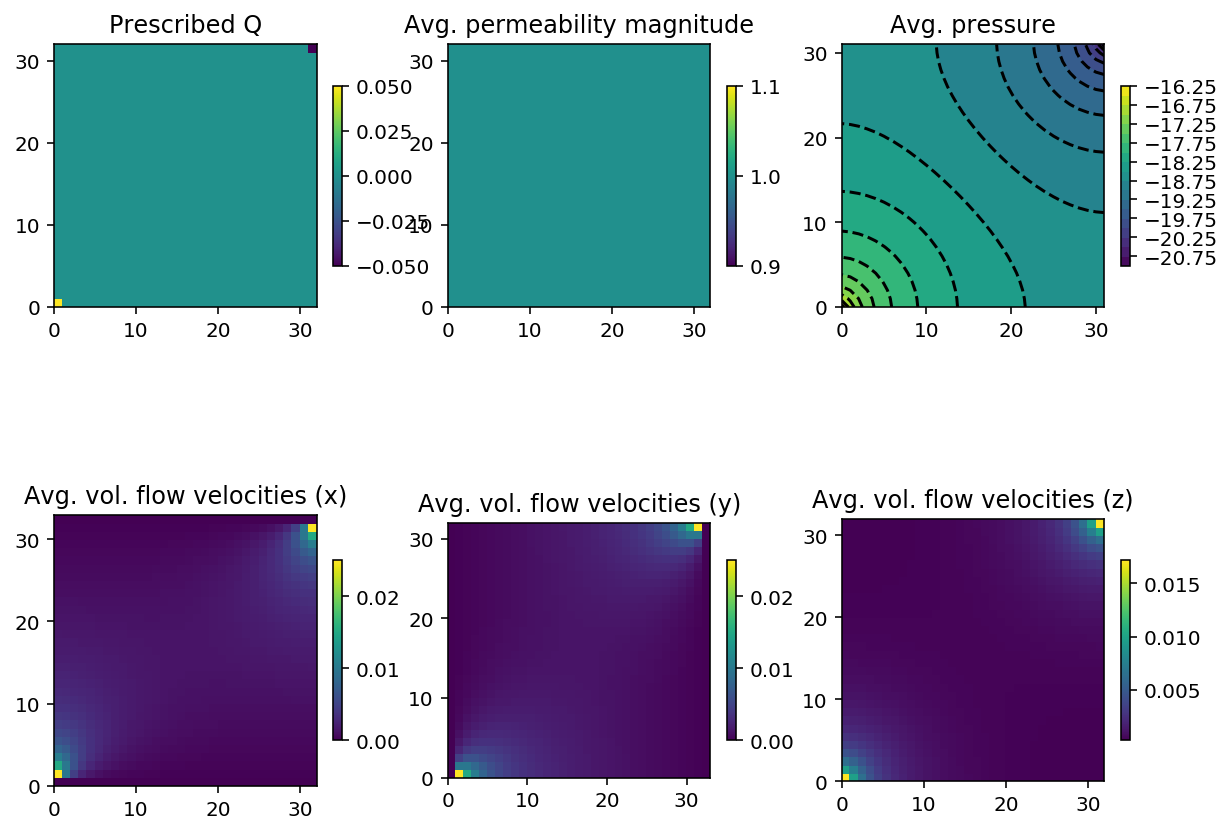

In [14]:
#Run isotropic case
K = np.ones((3, 32, 32, 20))
quarter_five_spot_single_phase_incompressible(K)

We can similarly run the same example, but now with log-normally distributed random anisotropic permeability. Notice that the flow velocities appear to be affected by the permeability (as is to be expected)

Largest pressure:  1.4737060149377008e-14
Smallest pressure:  -3.8794884686171347
Pressure difference:  3.8794884686171494


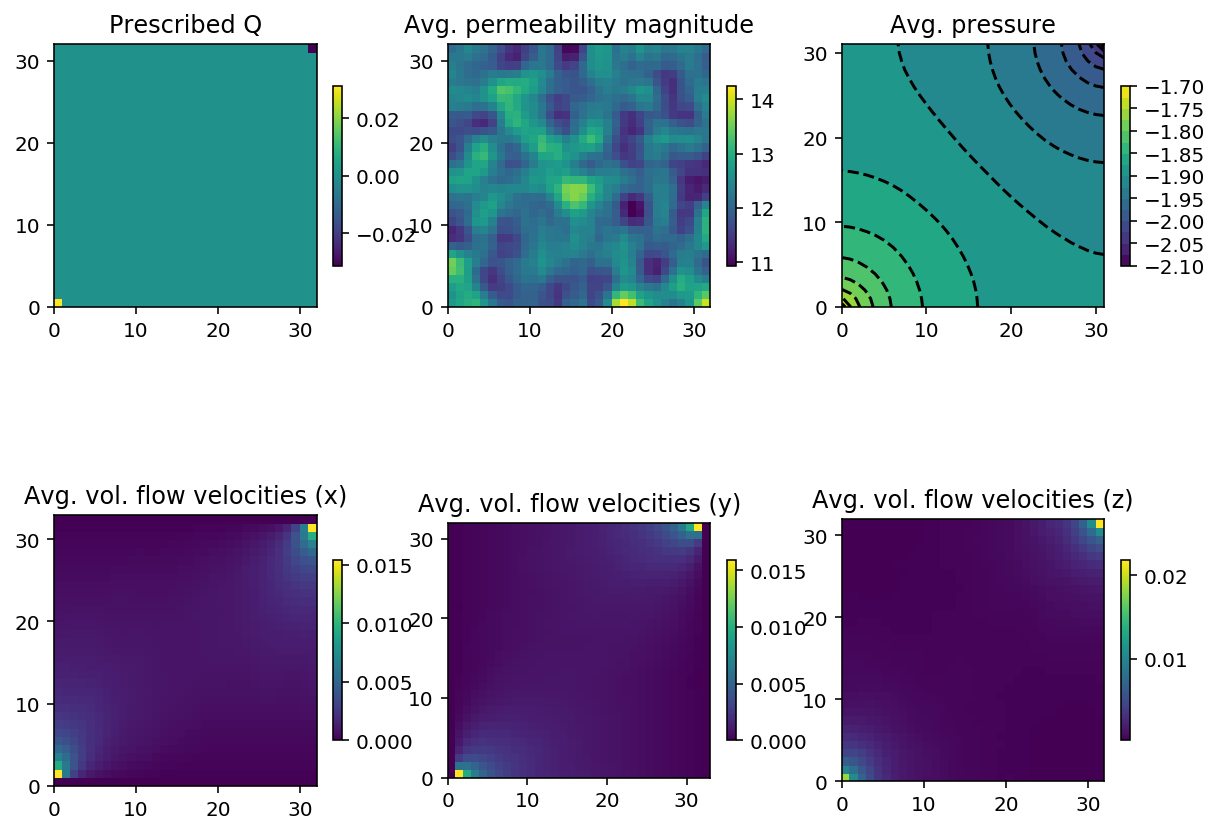

In [15]:
def smooth3(k):
    return sp.ndimage.uniform_filter(k, 3)

def quasi_random_perm(dims):
    np.random.seed(20000) # To make sure we get reproducible results
    return np.exp(5*smooth3(smooth3(np.random.random(dims))))

# Symmetric permeability diagonal tensor
K = quasi_random_perm((3, 32, 32, 32))
quarter_five_spot_single_phase_incompressible(K)

# Incompressible immiscible two-phase flow

Similarly to the single phase flow,
$$\frac{\partial}{\partial t} \phi \rho + \nabla \cdot (\rho\vec v) =  q$$
we can formulate the multi-phase flow as
$$\frac{\partial}{\partial t} \left( \phi \sum_\alpha c_{l\alpha} \rho_{\alpha} s_{\alpha} \right)
+ \nabla \cdot \left( \sum_\alpha c_{l\alpha} \rho_\alpha v_\alpha \right)
= \sum_\alpha c_{l\alpha} q_\alpha, 
\qquad \alpha = w, o, g
$$
where $\alpha$ denotes the phase ($w$ater, $o$il, $g$as), and $l$ denotes the individual components of these phases, i.e., $c_{l\alpha}$ is the mass fraction of component $l$ in phase $\alpha$. Equivalently we have that $\rho_\alpha$ is the density, $v_\alpha$ is the velocity, and $q_\alpha$ is the phase source. Again, this may be referred to as the continuity equation.

If we assume that we have only two phases, oil (consisting of the components black $o$il and dissolved $g$as) and $w$ater, and that these two do not mix, we can formulate the following rules:
$$
\begin{align}
    c_{ww} &= 1, &c_{ow} &= 0, & c_{gw} &= 0\\
    c_{wo} &= 0, &c_{oo} &= \frac{m_{o}}{m_o+m_g}, & c_{go} &= \frac{m_g}{m_o+m_g}\\
    c_{wg} &= 0, &c_{og} &= 0, & c_{gg} &= 0.
\end{align}
$$
Here $m_g$ and $m_o$ are the masses of gas and oil, respectively. 
Since we have that $c_{oo}+ c_{go} = 1$, we get two continuity equations (of for each phase) on the following form:
$$
\frac{\partial ( \phi \rho_\alpha s_\alpha )}{\partial t} + \nabla \cdot (\rho_\alpha\vec v_\alpha) =  q_\alpha
$$
We can rewrite these equations (by expansion through the product rule and dividing by $\rho_\alpha$) as
$$
\frac{\partial \phi}{\partial t} s_\alpha 
+ \phi\frac{\partial s_\alpha}{\partial t} 
+ \phi \frac{s_\alpha}{\rho_\alpha} \frac{\partial\rho_\alpha}{\partial t} 
+ \nabla \cdot v_\alpha
+ \frac{v_\alpha \cdot \nabla \rho_\alpha}{\rho_\alpha}
= 
\frac{q_\alpha}{\rho_\alpha}
$$
We can now sum the equations for the two phases as
$$
\frac{\partial \phi}{\partial t} (s_o + s_w) 
+ \phi\frac{\partial s_w}{\partial t} 
+ \phi\frac{\partial s_o}{\partial t} 
+ \phi \frac{s_w}{\rho_w} \frac{\partial\rho_w}{\partial t} 
+ \phi \frac{s_o}{\rho_o} \frac{\partial\rho_o}{\partial t} 
+ \nabla \cdot (v_w + v_o)
+ \frac{v_w \cdot \nabla \rho_w}{\rho_w}
+ \frac{v_o \cdot \nabla \rho_o}{\rho_o}
= 
\frac{q_w}{\rho_w}
+ \frac{q_g}{\rho_g}
$$
  
Using that $s_o + s_w = 1$ (and consequently $\frac{\partial s_o}{\partial t} + \frac{\partial s_w}{\partial t} = 0$), we simplify the above to
$$
\frac{\partial \phi}{\partial t} (s_o + s_w) 
+ \phi \frac{s_w}{\rho_w} \frac{\partial\rho_w}{\partial t} 
+ \phi \frac{s_o}{\rho_o} \frac{\partial\rho_o}{\partial t} 
+ \nabla \cdot (v_w + v_o)
+ \frac{v_w \cdot \nabla \rho_w}{\rho_w}
+ \frac{v_o \cdot \nabla \rho_o}{\rho_o}
= 
\frac{q_w}{\rho_w}
+ \frac{q_g}{\rho_g}
$$

## "Elliptic" pressure equation

Assuming no compressibility (constant $\rho$) and constant porosity ($\phi$), we simplify (just as for the single phase flow case) to
$$
\nabla \cdot (v_w + v_o)
= 
\frac{q_w}{\rho_w}
+ \frac{q_g}{\rho_g}
$$
Applying Darcy's law for multiphase velocities, 
$$
v_\alpha = -K\frac{k_{r_\alpha}}{\mu_\alpha}(\nabla p_\alpha - \rho_\alpha\nabla z),
$$
we get
$$
v = v_o + v_w = 
-K\frac{k_{r_w}}{\mu_w}(\nabla p_w - \rho_w\nabla z) 
-K\frac{k_{r_o}}{\mu_o}(\nabla p_o - \rho_o\nabla z),
$$
leading to
$$
\nabla \cdot \left[ 
-K\frac{k_{r_w}}{\mu_w}(\nabla p_w - \rho_w\nabla z) 
-K\frac{k_{r_o}}{\mu_o}(\nabla p_o - \rho_o\nabla z)
\right]
= 
\frac{q_w}{\rho_w}
+ \frac{q_g}{\rho_g}
$$
This equation has two unknown pressures, but we can eliminate one of these by introducing the global pressure, 
$$p = p_o - p_c,$$
in which $p_c$ is a function of the capillary pressure. However, assuming that the capillary pressure is constant, $p_c$ becomes zero (it is a function of the gradient of the capillary pressure), and the oil and water pressures become equal,
$$p = p_o = p_w.$$  
By introducing the total mobility
$$
\lambda = \lambda_w + \lambda_o = \frac{k_{r_w}}{\mu_w} + \frac{k_{r_o}}{\mu_o}
$$
and 
$$
q = \frac{q_w}{\rho_w}
+ \frac{q_g}{\rho_g}
$$
we can then write
$$
\begin{align}
\nabla \cdot \left[ 
-K\lambda_w(\nabla p_w - \rho_w\nabla z) 
-K\lambda_o(\nabla p_o - \rho_o\nabla z)
\right]
&= 
q
\\
-\nabla \cdot \left[ 
K\lambda\nabla p
-K\lambda_w(\rho_o + \rho_w) \nabla z
\right]
&= 
q
\end{align}
$$
By further neglecting gravitational forces (just as for the single phase case), we end up with
$$
-\nabla \cdot \left[ 
K\lambda\nabla p
\right]
= 
q
$$
as our elliptic pressure equation. 

### Discretization
The mobilities $\lambda_o$ and $\lambda_w$ must be specified, as these are functions of the relative permeabilities (recall that the relative permeabilities are functions of the saturation). We will here use simple analytical expressions,
$$
\lambda_w(s) = \frac{(s^*)^2}{\mu_w}, \qquad \lambda_o(s) = \frac{(1-s^*)^2}{\mu_o}, \qquad s^* = \frac{s - s_{wc}}{1-s_{or}-s_{wc}}.
$$
Here, $s_{or}$ is the irreducible oil saturation (the lowest oil saturation that can be achieved by displacing oil with water), and $s_{wc}$ is the connate water saturation, that is the water trapped in pores during the rock formation. 
We now have everything we need to solve the pressure equation numerically. Recalling the single phase pressure equation (incompressible and without gravitational terms),
$$ 
\nabla \cdot v = \frac{q}{\rho}\\
\nabla \cdot \left[
\frac{K}{\mu}\nabla p
\right] = \frac{q}{\rho}
$$
we see that our two-phase equation is quite similar,
$$
\begin{align}
-\nabla \cdot \left[ 
K\lambda\nabla p
\right]
&= 
q
\\
-\nabla \cdot \left[ 
K\left( \frac{k_{r_w}}{\mu_w} + \frac{k_{r_o}}{\mu_o} \right)\nabla p
\right]
&= 
q
\end{align},
$$
and we can use the same two-point flux-approximation to solve it by replacing $K/\mu$ with $K\lambda$.

In [16]:
class Fluid:
    """ A kind of "C struct" """
    pass

In [17]:
def mobilities(s, fluid):
    """
    Computes the relative permeabilities, $\lambda = \lambda_w + \lambda_o$
    
    
    Parameters
    ----------
    s: Saturation
    fluid: "C"-like struct containing
        s_wc: Connate water saturation
        s_or: Irreducible oil saturation
        mu_w: Water viscosity
        mu_o: Oil viscosity
    """
    
    #Find the non-occupied space
    f = (1.0 - fluid.s_wc - fluid.s_or)
    
    #Compute s*
    S = (s - fluid.s_wc) / f
    
    #Compute the mobilities
    lambda_w = S**2 / fluid.mu_w
    lambda_o = (1-S)**2 / fluid.mu_o
    
    #Compute derivatives of mobilities
    d_lambda_w = (2.0*S / fluid.mu_w) / f
    d_lambda_o = (-2.0*(1.0 - S) / fluid.mu_o) / f
    
    return [lambda_w, lambda_o, d_lambda_w, d_lambda_o]

Let us now test the mobilities function to see that it behaves as expected.

In [23]:
def test_mobilities(mu_w, mu_o):
    f = Fluid()

    # Set fluid properties
    f.s_wc = 0.0
    f.s_or = 0.0
    f.mu_w = mu_w
    f.mu_o = mu_o

    #Create saturations
    s = np.arange(0, 1, 0.01)

    [lambda_w, lambda_o, d_lambda_w, d_lambda_o] = mobilities(s, f);
    f = lambda_w / (lambda_w + lambda_o)
    df = d_lambda_w / (lambda_w + lambda_o) - lambda_w * (d_lambda_w + d_lambda_o) / (lambda_w + lambda_o)**2 

    plot(s, f, 'b', label='f(s)')
    plot(s, df, 'k', label='df(s)')
    #axis('image')
    xlabel("Saturation s")
    ylabel("f(s)")
    legend()
    a = "mu_w=" + str(mu_w) + ", mu_o=" + str(mu_o)
    title(a)

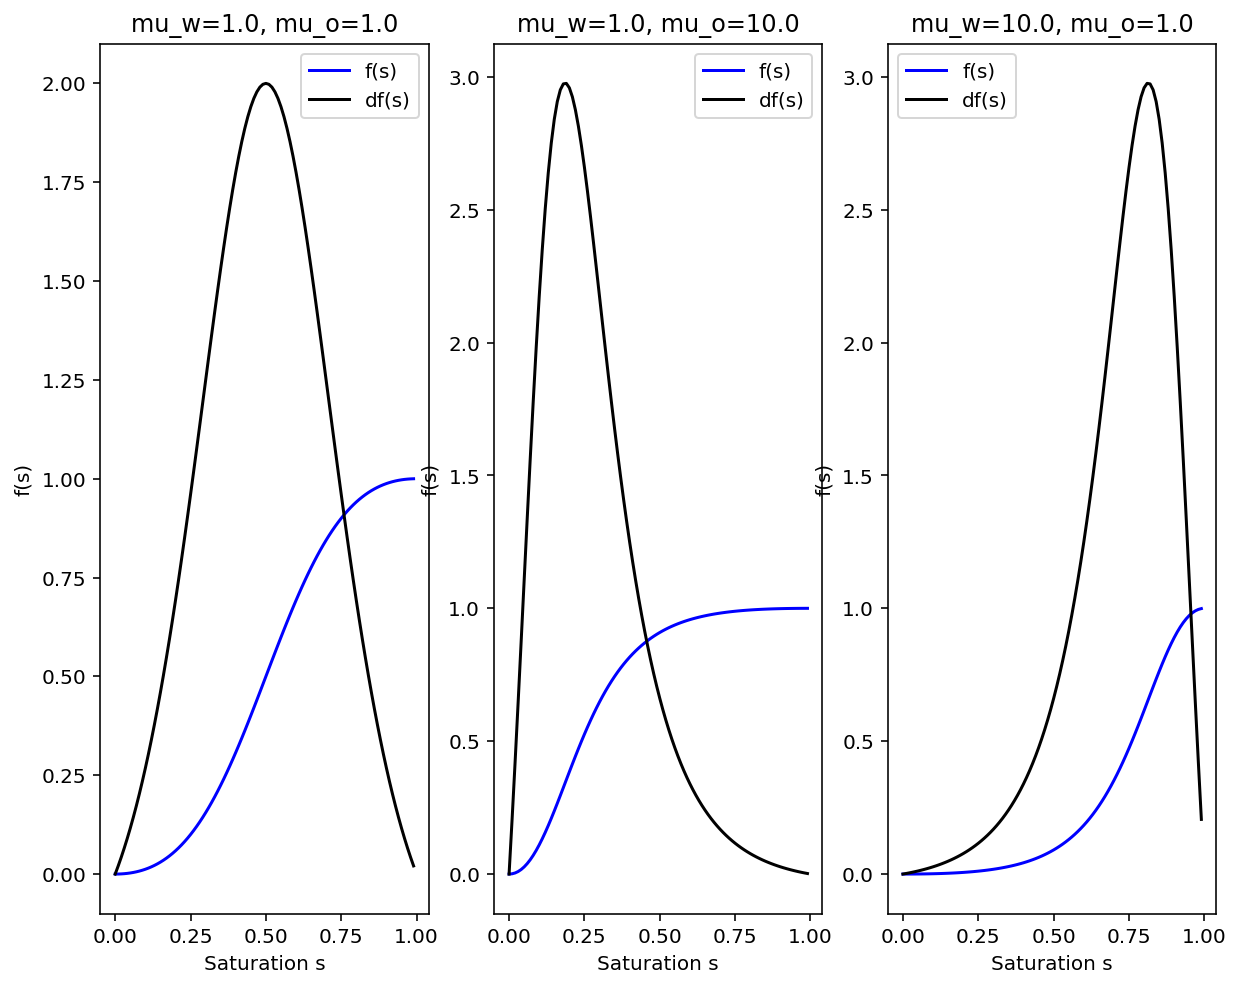

In [24]:
subplot(1,3,1)
test_mobilities(1.0, 1.0)

subplot(1,3,2)
test_mobilities(1.0, 10.0)

subplot(1,3,3)
test_mobilities(10.0, 1.0)

In [25]:
def TPFA_twophase(grid, K, q, s, fluid):
    """
    Computes the water pressure of a two-phase flow using the
    two-point flux-approximation
        
    Parameters
    ----------
    grid: See TPFA
    K: See TPFA
    q: See TPFA
    fluid: fluid properties struct, containing
        s_wc: Connate water saturation
        s_or: Irreducible oil saturation
        mu_w: Water viscosity
        mu_o: Oil viscosity
    """
    # lmda => lambda
    [lmda_w, lmda_o, _, _] = mobilities(s, fluid)
    lmda = lmda_w + lmda_o    
    
    L = zeros(K.shape)
    L[0,:,:,:] = K[0,:,:,:] * lmda
    L[1,:,:,:] = K[1,:,:,:] * lmda
    L[2,:,:,:] = K[2,:,:,:] * lmda
                
    return TPFA(grid, L, q)

Let us now test the twophase TPFA

In [26]:
def test_TPFA_twophase(K, s, mu_w, mu_o):
    k_shape = K.shape
    assert k_shape[0] == 3
    
    # Set grid size
    g = Grid()
    g.nx = k_shape[1]
    g.ny = k_shape[2]
    g.nz = k_shape[3]
    
    # Set domain size
    g.dx = 1.0/(g.nx)
    g.dy = 1.0/(g.ny)
    g.dz = 1.0/(g.nz)
    
    # Set fluid properties
    f = Fluid()
    f.s_wc = 0.0
    f.s_or = 0.0
    f.mu_w = mu_w
    f.mu_o = mu_o
    
    # Set Q
    q = np.zeros((g.nx, g.ny, g.nz))
    q[0][0][0] = 1.0
    q[-1][-1][-1] = -1.0
    rho = 1.0
    
    #Compute pressure
    [P, vx, vy, vz] = TPFA_twophase(g, K, q/rho, s, f)
    plot_solution(q, K, P, vx, vy, vz)

Largest pressure:  1.9299880656619638e-13
Smallest pressure:  -49.610389479727274
Pressure difference:  49.610389479727466


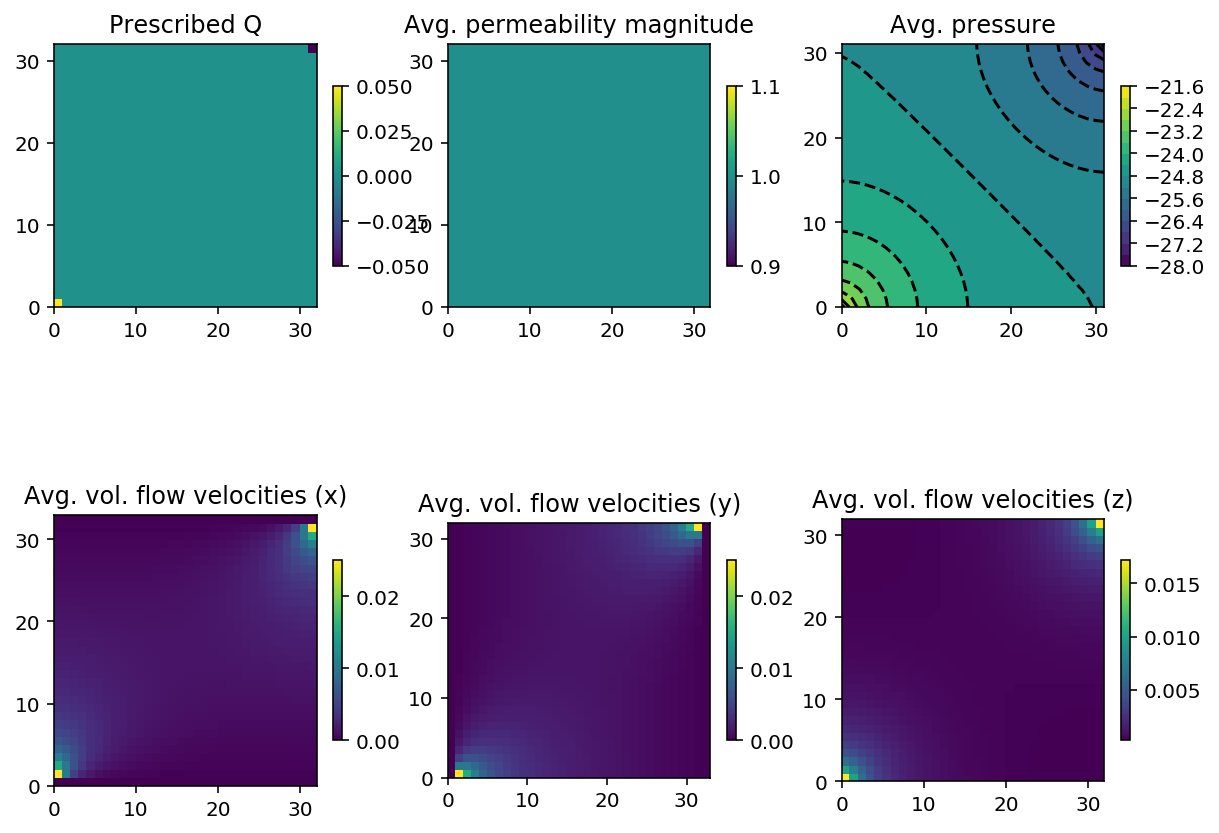

In [27]:
#Should not be the same as single phase flow (oil present)
K = np.ones((3, 32, 32, 20))
s = np.ones((32, 32, 20))*0.5
test_TPFA_twophase(K, s, 1.0, 0.5);

Largest pressure:  1.1103832395003039e-13
Smallest pressure:  -37.20779210979733
Pressure difference:  37.207792109797445


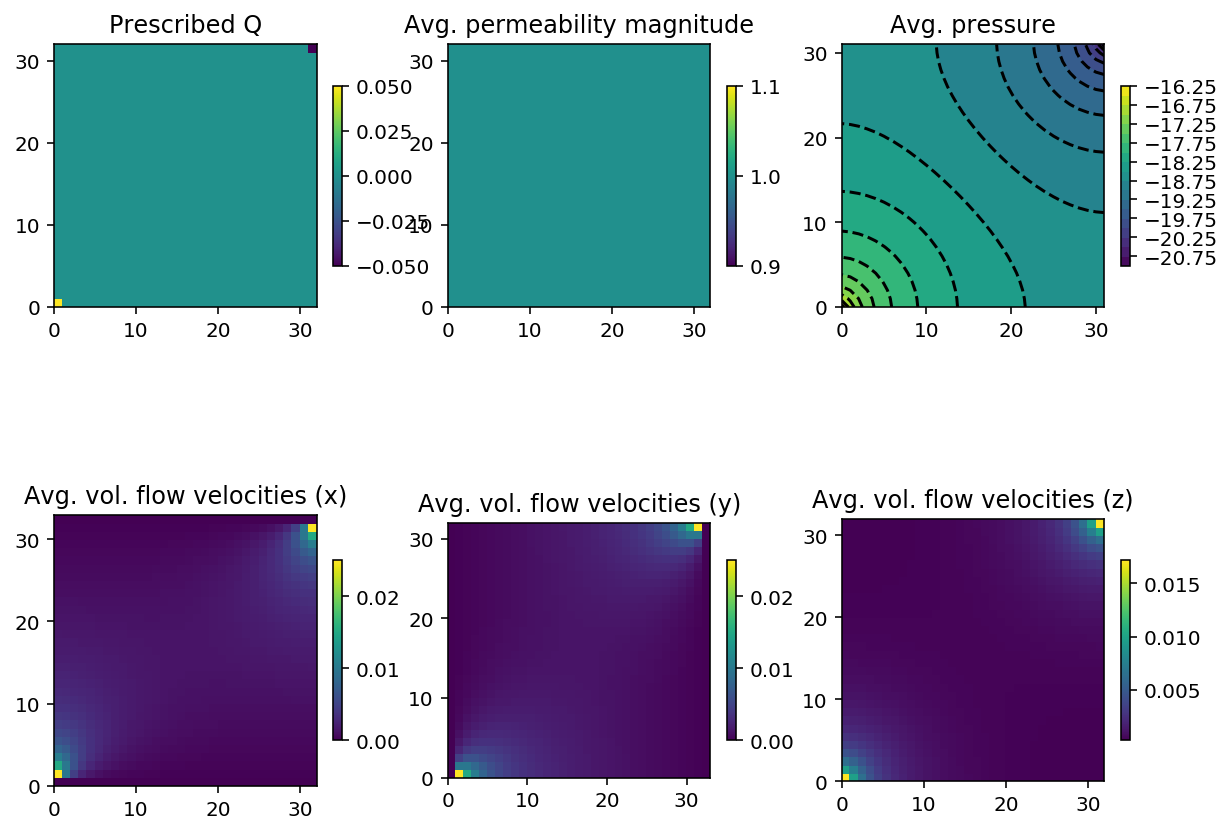

In [28]:
#Should be the same as single phase flow (no oil present)
K = np.ones((3, 32, 32, 20))
s = np.ones((32, 32, 20))
test_TPFA_twophase(K, s, 1.0, 0.5);

## "Hyperbolic" saturation equation
Going back to our continuity equations,
$$
\frac{\partial ( \phi \rho_\alpha s_\alpha )}{\partial t} + \nabla \cdot (\rho_\alpha\vec v_\alpha) =  q_\alpha, \qquad \alpha = {o,w}
$$
we can now use the fact $s_w + s_o = 1$ to derive the saturation equation for water alone, and from this deduce the oil saturation directly. Dividing the water saturation equation by the density $\rho_w$, we get
$$
\frac{\partial ( \phi s_w )}{\partial t} + \nabla \cdot (\vec v_w) =  \frac{q_w}{\rho_w}.
$$
We now need the expression for the velocity $\vec v_w$, which we can derive as follows:
$$
\begin{align}
\lambda_o v_w - \lambda_w v_o
&=
-\lambda_o K\frac{k_{r_w}}{\mu_w}(\nabla p_w - \rho_w\nabla z) 
+\lambda_w K\frac{k_{r_o}}{\mu_o}(\nabla p_o - \rho_o\nabla z)
\\
&= 
-\lambda_o K\lambda_w(\nabla p_w - \rho_w\nabla z) 
+\lambda_w K\lambda_o(\nabla p_o - \rho_o\nabla z)
\\
&=
-\lambda_w\lambda_o K \left[(\nabla p_w - \rho_w\nabla z) 
+(\nabla p_o - \rho_o\nabla z) \right]\\
\end{align}
$$
Dividing by $\lambda_o + \lambda_w$, and inserting $v_o = v - v_w$ we then get
$$
\begin{align}
\frac{\lambda_o v_w - \lambda_w v_o}{\lambda_o + \lambda_w}
&=
-f_w\lambda_o
K \left[(\nabla p_w - \rho_w\nabla z) 
+(\nabla p_o - \rho_o\nabla z) \right]
\\
\frac{\lambda_o v_w}{\lambda_o + \lambda_w}
- \frac{\lambda_w (v - v_w)}{\lambda_o + \lambda_w}
&=
-f_w\lambda_o
K \left[(\nabla p_w - \rho_w\nabla z) 
+(\nabla p_o - \rho_o\nabla z) \right]
\\
\frac{\lambda_o v_w}{\lambda_o + \lambda_w}
- \frac{\lambda_w (v - v_w)}{\lambda_o + \lambda_w}
&=
-f_w\lambda_o
K \left[(\nabla p_w - \rho_w\nabla z) 
+(\nabla p_o - \rho_o\nabla z) \right]
\\
f_o v_w
- f_w (v-v_w)
&=
-f_w\lambda_o
K \left[(\nabla p_w - \rho_w\nabla z) 
-(\nabla p_o - \rho_o\nabla z) \right]
\\
v_w 
- f_w v
&=
-f_w\lambda_o
K \left[(\nabla p_w - \rho_w\nabla z) 
-(\nabla p_o - \rho_o\nabla z) \right]
\end{align}
$$

By neglecting gravitational terms, and using that $p_w = p_o$ (and consequently $\nabla p_w = \nabla p_o$), we end up with
$$
v_w = f_w v
$$
which we insert into our continuity equation for the water phase,
$$
\frac{\partial ( \phi s_w )}{\partial t} + \nabla \cdot (f_w v) =  \frac{q_w}{\rho_w},
$$ 
and we have our saturation equation. Since we inject only water, and produces whatever comes out, we can write our source term as
$$
\frac{q_w}{\rho_w} = \text{max}(q, 0) + f_w(s) \text{min}(q, 0)
$$
leading to 
$$
\frac{\partial ( \phi s_w )}{\partial t} + \nabla \cdot (f_w v)
=
\text{max}(q, 0) + f_w(s) \text{min}(q, 0)
$$

### Explicit Discretization of Saturation

By using an explicit discretization of the saturation equation, we get a so-called IMPES scheme - Implicit Pressure Explicit Saturation.

We can discretize our saturation equation using a finite volume formulation in space, and explicitly in time 
$$
\frac{\phi_i }{\Delta t} \left( s_i^{k+1} - s_i^k \right) + \frac{1}{|\Omega_i|} \sum_j \left(f_w(s^k)_{ij} v_{ij}\right)
=
\text{max}(\frac{q_i}{\rho_i}, 0) + f_w(s_i^k) \text{min}(\frac{q_i}{\rho_i}, 0)
$$
Here, $s_i^k$ is the cell average of the water saturation at time $t_k$, $f_w(s^k)_{ij}$ is the fractional flow function evaluated at the interface between cells $i$ and $j$, and equivalently for the velocity $v_{ij}$  
Rewriting this into 
$$
s_i^{k+1}
=
s_i^k 
+ \frac{\Delta t}{\phi_i |\Omega_i|} 
\left(
\text{max}(\frac{q_i}{\rho_i}, 0) 
- \sum_j (f_w(s^k)_{ij} v_{ij})
+ f_w(s_i^k) \text{min}(\frac{q_i}{\rho_i}, 0)
\right)
$$
Using an upwind weighing of the fractional flow, 
$$
f_w(s^k)_{ij} = 
\left\{ 
\begin{align}
f_w(s_i^k)\quad \text{if}\quad v\cdot n_{ij} \geq 0\\
f_w(s_j^k)\quad \text{if}\quad v\cdot n_{ij} \lt 0
\end{align}
\right.
$$
we now have everything we need to solve the explicit saturation equation.
We can write the equation above on matrix form as
$$
S^{n+1} = S^n + (\delta_x^t)^T(A f(S^n) + Q^+), \qquad \delta_x^t = \frac{\Delta t}{\phi_i |\Omega_i|}
$$  
in which the matrix-vector product $A f(S^n)$ implements $[f(s_i) Q^- - \nabla \cdot(f(s)_{ij}v_{ij})].$ We can implement the $A$ matrix as follows.

In [29]:
def compute_A(grid, vx, vy, vz, q):
    """
    Computes the A matrix, so that Af(S^m) implements [f(s_i)Q^- - \nabla \cdot (f(s)_{ij}v_{ij})] with
    upwinding
    
    Parameters
    ----------
    grid: See TPFA
    vx: Matrix of face velocities along x
    vy: Matrix of face velocities along y
    vz: Matrix of face velocities along z
    q: See TPFA
    """
    
    #Shorthand for grid dimensions
    nx = grid.nx
    ny = grid.ny
    nz = grid.nz
    N = nx*ny*nz
    
    # Q^-
    Qm = np.minimum(q, 0.0)
    Qm = np.reshape(Qm, (1, N), order='F')
    
    #Flow out of cell i to the "left"
    XN = np.minimum(vx[0:nx,:,:], 0.0)
    YN = np.minimum(vy[:,0:ny,:], 0.0)
    ZN = np.minimum(vz[:,:,0:nz], 0.0)
    
    x1 = np.reshape(XN, (1, N), order='F')
    y1 = np.reshape(YN, (1, N), order='F')
    z1 = np.reshape(ZN, (1, N), order='F')
    
    #Flow out of cell i to the "right"
    XP = np.maximum(vx[1:nx+1,:,:], 0.0)
    YP = np.maximum(vy[:,1:ny+1,:], 0.0)
    ZP = np.maximum(vz[:,:,1:nz+1], 0.0)
    
    x2 = np.reshape(XP, (1, N), order='F')
    y2 = np.reshape(YP, (1, N), order='F')
    z2 = np.reshape(ZP, (1, N), order='F')
    
    # Assemble A, and use the fact that 
    # x1, y1, z1 are zero or negative (flux going "left"), and similarly that
    # x2, y2, z2 are zero or positive (flux going "right")
    # to implement the upwinding (when multiplied with f(S^m))
    diag_vecs = np.vstack([z2, y2, x2, Qm+x1-x2+y1-y2+z1-z2, -x1, -y1, -z1])
    diag_index = np.array([-nx*ny, -nx, -1, 0, 1, nx, nx*ny])
    A = sp.sparse.spdiags(diag_vecs, diag_index, N, N, format='csr')

    return A

Let us now look at what A can be

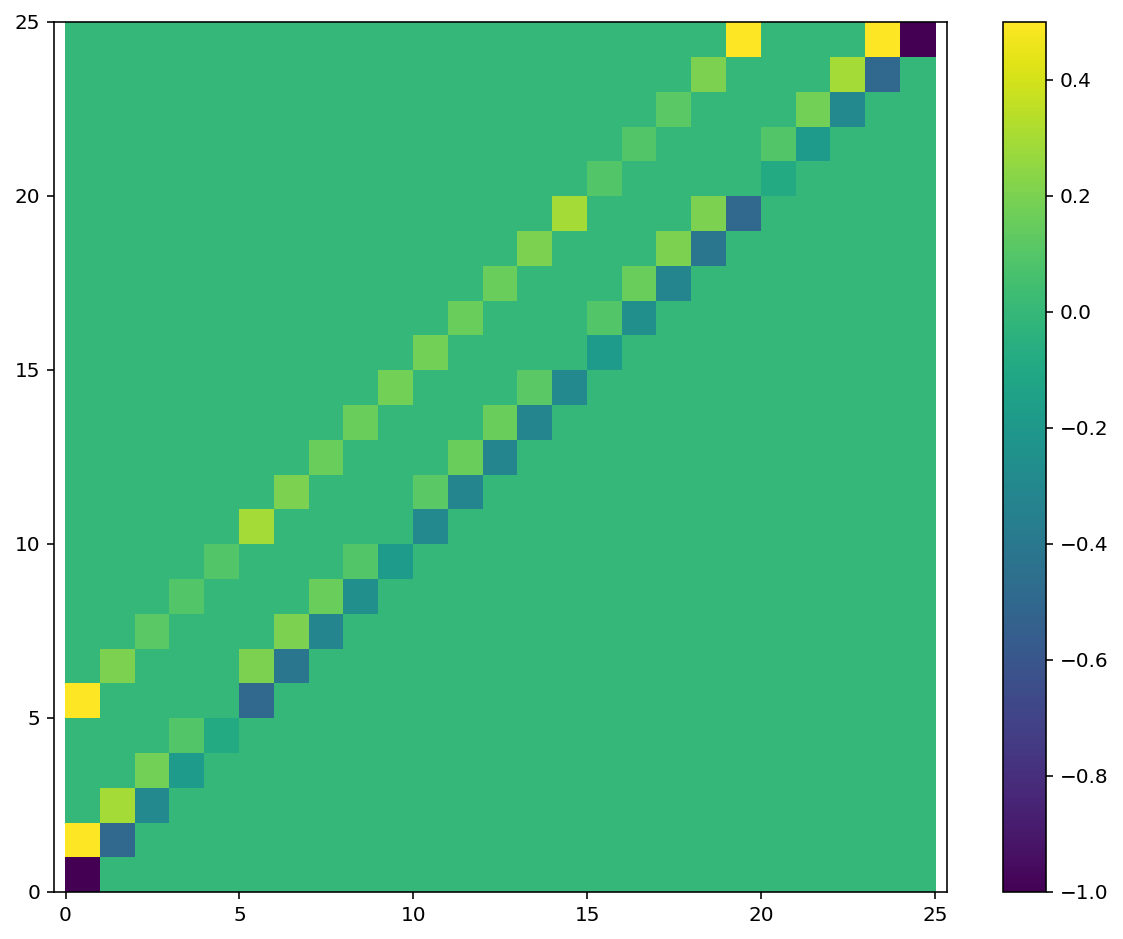

In [30]:
def test_compute_A(K, s, mu_w, mu_o):
    k_shape = K.shape
    assert k_shape[0] == 3
    
    # Set grid size
    grid = Grid()
    grid.nx = k_shape[1]
    grid.ny = k_shape[2]
    grid.nz = k_shape[3]
    N = grid.nx*grid.ny*grid.nz
    
    # Set domain size
    grid.dx = 1.0/(grid.nx)
    grid.dy = 1.0/(grid.ny)
    grid.dz = 1.0/(grid.nz)
    
    # Set fluid properties
    fluid = Fluid()
    fluid.s_wc = 0.0
    fluid.s_or = 0.0
    fluid.mu_w = mu_w
    fluid.mu_o = mu_o
    
    # Set Q
    q = np.zeros((grid.nx, grid.ny, grid.nz))
    q[0][0][0] = 1.0
    q[-1][-1][-1] = -1.0
    rho = 1.0
    
    #Compute pressure
    [P, vx, vy, vz] = TPFA_twophase(grid, K, q/rho, s, fluid)
    
    #Compute the A matrix
    A = compute_A(grid, vx, vy, vz, q)
    
    plt = figure()
    pcolor(np.array(A.todense()))
    colorbar()
    axis('equal')
    
#Should not be the same as single phase flow (oil present)
K = np.ones((3, 5, 5, 1))
s = np.zeros((5, 5, 1))*0.5
test_compute_A(K, s, 1.0, 0.5);

The final thing we need, is the CFL condition which is a standard requirement for such explicit schemes. In our case, the CFL condition can be derived to be the following
$$
\begin{align}
\Delta t 
&\leq \frac{\phi |\Omega_i|}{v^\text{in} \text{max}(f_w'(s))_{0 \leq s \leq 1}} \\
&= \frac{\phi|\Omega_i|}{v^{\text{in}}} \cdot \left[\frac{1}{1 -s_{wc} - s_{or}} \cdot \frac{\partial f}{\partial s^*}\right]^{-1}, \qquad v^\text{in} = Q^+ - \sum_j \text{min}(v_{ij}, 0)
\end{align}
$$
Computing $\frac{\partial f}{\partial s^*}$ can be challenging in practice, and we therefore simply estimate this term to be equal 3.
With the matrix $A$ computed, and the CFL in place, we can proceed to implement
$$
S^{n+1} = S^n + (\delta_x^t)^T(A f(S^n) + Q^+), \qquad \delta_x^t = \frac{\Delta t}{\phi_i |\Omega_i|}
$$  

In [31]:
def upstream(grid, s, fluid, vx, vy, vz, q, phi, T):
    """
    Computes the saturation at time t = t+T using the current saturation s,
    the volumetric velocities [vx, vy, vz], and the sources q.
    """
    
    #Shorthand for grid dimensions
    nx = grid.nx
    ny = grid.ny
    nz = grid.nz
    N = nx*ny*nz
        
    #Calculate the per cell volume, |\Omega_i|
    omega = grid.dx*grid.dy*grid.dz;
    
    #Find inflow from wells, Q^+
    Qp = np.maximum(q, 0.0)
    
    #Find flux going into the cell from the "right" interfaces
    XM = -np.minimum(vx[1:nx+1,:,:], 0.0)
    YM = -np.minimum(vy[:,1:ny+1,:], 0.0)
    ZM = -np.minimum(vz[:,:,1:nz+1], 0.0)
    
    #Find the flux going into the cell from the "left" interfaces
    XP = np.maximum(vx[0:nx,:,:], 0.0)
    YP = np.maximum(vy[:,0:ny,:], 0.0)
    ZP = np.maximum(vz[:,:,0:nz], 0.0)
    
    #Find total flux into each cell, Q^+ - \sum_j min(v_ij, 0)
    Vi = XP + YP + ZP + XM + YM + ZM + Qp
    
    #Compute the CFL
    cfl = (np.min(phi*omega / Vi)) * (1.0 -fluid.s_wc - fluid.s_or) * (1.0/3.0)
    
    #Find the number of timesteps we need to take to reach T
    n_ts = int(np.ceil(T/cfl))
    dt = T / float(n_ts)
    
    # Compute \delta_x^t
    d_xt = dt / (phi*omega)
            
    #Find the A matrix
    A = compute_A(grid, vx, vy, vz, q)
    
    #Reshape our matrices into vectors
    s = np.reshape(s, (N, 1), order='F')
    Qp = np.reshape(Qp, (N, 1), order='F')
    d_xt = np.reshape(d_xt, (N, 1), order='F')
    
    for i in range(n_ts):
        [lmbd_w, lmbd_o, _, _] = mobilities(s, fluid)
        f = lmbd_w / (lmbd_w + lmbd_o)
        s = s + d_xt*(A*f + Qp)
    
    s = np.reshape(s, (nx, ny, nz), order='F')
    return s

We are finally ready to run a simulation

In [35]:
def quarter_five_spot_two_phase_incompressible_impes(K, phi):
    g = Grid()
    f = Fluid()
    
    k_shape = K.shape
    assert k_shape[0] == 3
    
    volumetric = False
    if (K.shape[3] > 1):
        volumetric = True
        
    # Set grid size
    g.nx = k_shape[1]
    g.ny = k_shape[2]
    g.nz = k_shape[3]
    
    # Set domain size
    g.dx = 1.0 / g.nx
    g.dy = 1.0 / g.ny
    g.dz = 1.0 / g.nz
        
    # Set fluid properties
    f.s_wc = 0.0
    f.s_or = 0.0
    f.mu_w = 1.0
    f.mu_o = 1.0
    
    #Set sources/sinks
    q = np.zeros((g.nx, g.ny, g.nz))
    q[0][0][0] = 1.0
    q[-1][-1][-1] = -1.0
    rho = 1.0
    
    #Set initial saturation
    s = np.zeros((g.nx, g.ny, g.nz))
    
    #Set dt for pressure solves,
    #and total simulation time
    nt = 25
    dt = 0.7 / (nt-1)
    
    #for plotting a lot of figures in one
    nx = int(ceil(sqrt(nt)))
    ny = nx
    if (nx*(ny-1) > nt):
        ny = ny-1
    
    #2d plot
    fig_2d, ax_2d = subplots(nx, ny, sharex=True, sharey=True, squeeze=True)
    ax_2d = np.reshape(ax_2d, nx*ny)
    subplots_adjust(right=0.8, wspace=0.1, hspace=0.1)
    coll = None
    X = np.linspace(0, 1, g.nx)
    Y = np.linspace(0, 1, g.ny)
    X, Y = np.meshgrid(X, Y)
    
    #3d plot
    if (volumetric):
        fig_3d, ax_3d = subplots(nx, ny, sharex=True, sharey=True, squeeze=True)
        ax_3d = np.reshape(ax_3d, nx*ny)
        subplots_adjust(wspace=0, hspace=0)
        a = min(g.dx, g.dy, g.dz)
        dx = g.dx / a
        dy = g.dy / a
        dz = g.dz / a
    
    #Finally, simulation loop
    for t in range(nt):
        #Compute the pressure
        [P, vx, vy, vz] = TPFA_twophase(g, K, q/rho, s, f)
        
        #Update saturations
        s = upstream(g, s, f, vx, vy, vz, q, phi, dt)
        
        #2d plot
        coll = ax_2d[t].contour(X, Y, np.average(s, axis=2), 18, colors='k', vmin=0.0, vmax=1.0)
        coll = ax_2d[t].contourf(X, Y, np.average(s, axis=2), 18, vmin=0.0, vmax=1.0)
        #coll = ax_2d[t].pcolor(np.average(s, axis=2), vmin=0.0, vmax=1.0)
        axis('tight')
        
        #3d plot
        if (False):
            volume = mlab.pipeline.scalar_field(s)
            volume.spacing = [dx, dy, dz]
            volume.update_image_data = True
            mlab.pipeline.volume(volume, vmin=0.0, vmax=1.0)
            mlab.axes()
            ax_3d[t].imshow(mlab.screenshot())
            ax_3d[t].axis('off')
            mlab.close()
        
        print("t=", t*dt, ", Max P=", np.max(P), ", Min P=", np.min(P), ", Max S=", np.max(s), ", Min S=", np.min(s))
        
        #Force garbage collection
        gc.collect()
        
    #Add colorbar
    c_ax = fig_2d.add_axes([0.85, 0.15, 0.05, 0.7])
    fig_2d.colorbar(coll, cax=c_ax)
        
    #Turn off the axis in unused subplots
    for t in range(nt+1, nx*ny):
        ax_2d[t].axis('off')

t= 0.0 , Max P= 6.938893903907228e-16 , Min P= -10.715083397247513 , Max S= 0.9732761206063039 , Min S= 0.0
t= 0.029166666666666664 , Max P= 1.454392162258955e-14 , Min P= -12.037194095165948 , Max S= 0.9854403509666684 , Min S= 0.0
t= 0.05833333333333333 , Max P= -5.551115123125783e-16 , Min P= -11.756205546931083 , Max S= 0.9899400906098917 , Min S= 0.0
t= 0.0875 , Max P= 8.743006318923108e-15 , Min P= -11.612335121097882 , Max S= 0.9923012435046432 , Min S= 0.0
t= 0.11666666666666665 , Max P= -1.5626389071599078e-14 , Min P= -11.520371321308764 , Max S= 0.9937595608120939 , Min S= 0.0
t= 0.14583333333333331 , Max P= 2.4702462297909733e-15 , Min P= -11.454439289590539 , Max S= 0.9947510324340977 , Min S= 0.0
t= 0.175 , Max P= -1.27675647831893e-14 , Min P= -11.40479240048113 , Max S= 0.9954694216229771 , Min S= 0.0
t= 0.20416666666666664 , Max P= -1.7763568394002505e-14 , Min P= -11.36638845181066 , Max S= 0.9960141396182974 , Min S= 0.0
t= 0.2333333333333333 , Max P= 1.1907141939104

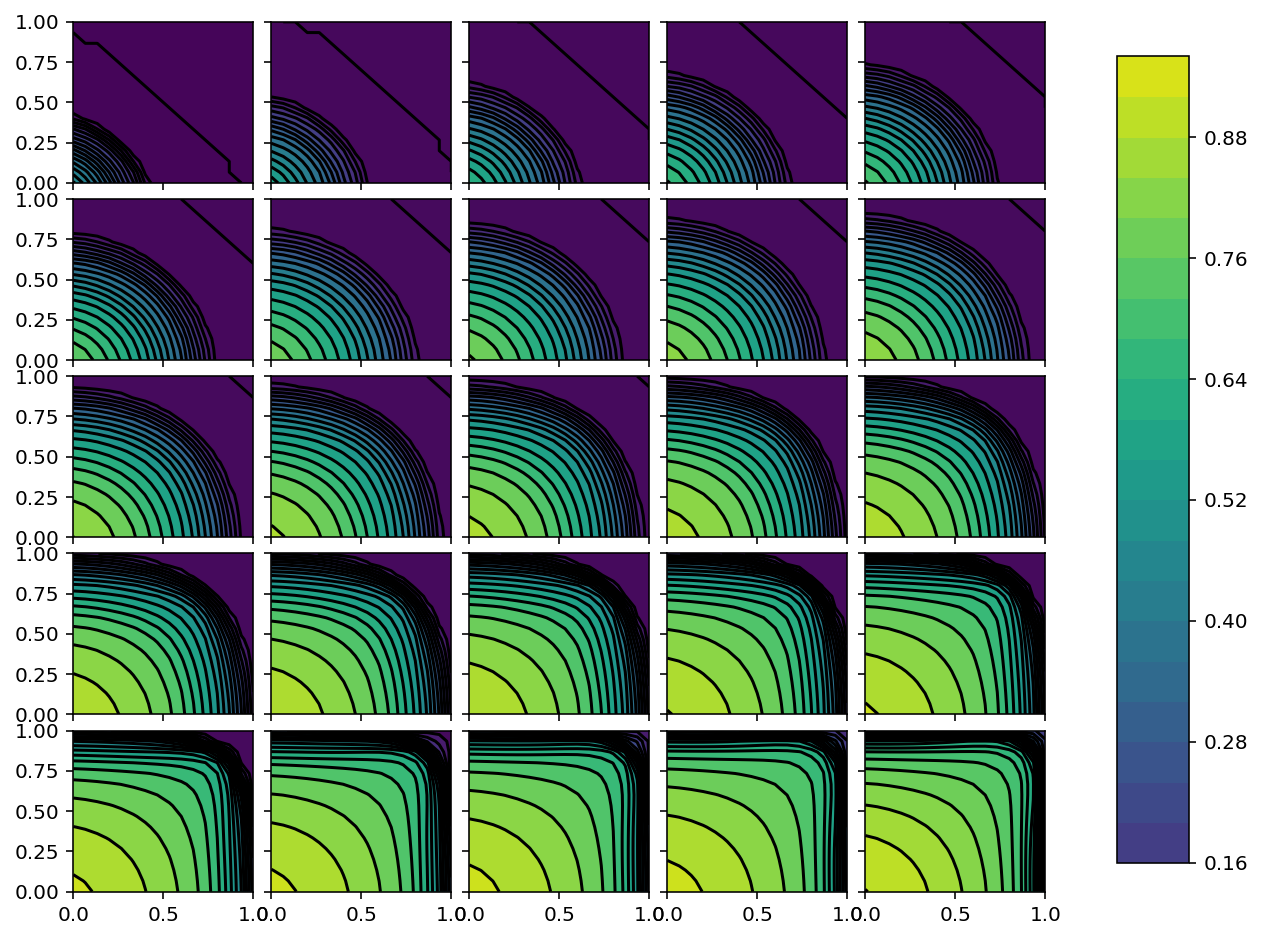

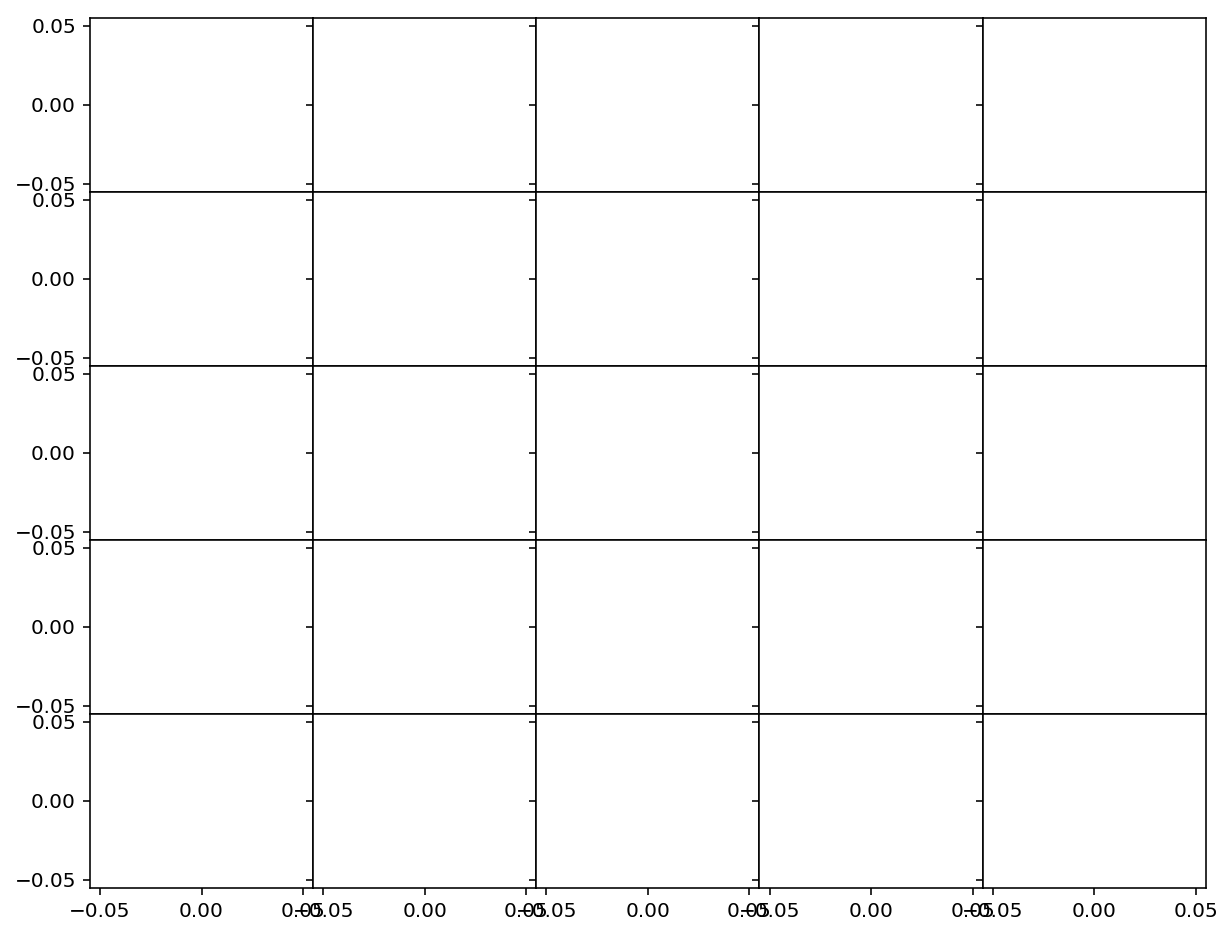

In [36]:
#Run isotropic case
K = np.ones((3, 16, 16, 4))
phi = np.ones((16, 16, 4))
quarter_five_spot_two_phase_incompressible_impes(K, phi)

t= 0.0 , Max P= 7.17199737099e-15 , Min P= -2.35805201487 , Max S= 0.996785886049 , Min S= 0.0
t= 0.0291666666667 , Max P= 6.90853624308e-15 , Min P= -2.45686330684 , Max S= 0.998364323361 , Min S= 0.0
t= 0.0583333333333 , Max P= 8.95095629561e-15 , Min P= -2.43285435271 , Max S= 0.998902261827 , Min S= 0.0
t= 0.0875 , Max P= 6.81030752625e-15 , Min P= -2.42127380532 , Max S= 0.99917375392 , Min S= 0.0
t= 0.116666666667 , Max P= 2.81025203108e-15 , Min P= -2.4141801373 , Max S= 0.99933751801 , Min S= 0.0
t= 0.145833333333 , Max P= 5.64262178648e-15 , Min P= -2.409297081 , Max S= 0.999447074954 , Min S= 0.0
t= 0.175 , Max P= 2.11571211939e-15 , Min P= -2.40569444218 , Max S= 0.999525523739 , Min S= 0.0
t= 0.204166666667 , Max P= 5.16362126668e-15 , Min P= -2.40295004969 , Max S= 0.999584469697 , Min S= 0.0
t= 0.233333333333 , Max P= 7.93570938129e-15 , Min P= -2.40080357247 , Max S= 0.999630383061 , Min S= 0.0
t= 0.2625 , Max P= 1.76876742419e-15 , Min P= -2.39910245896 , Max S= 0.99966

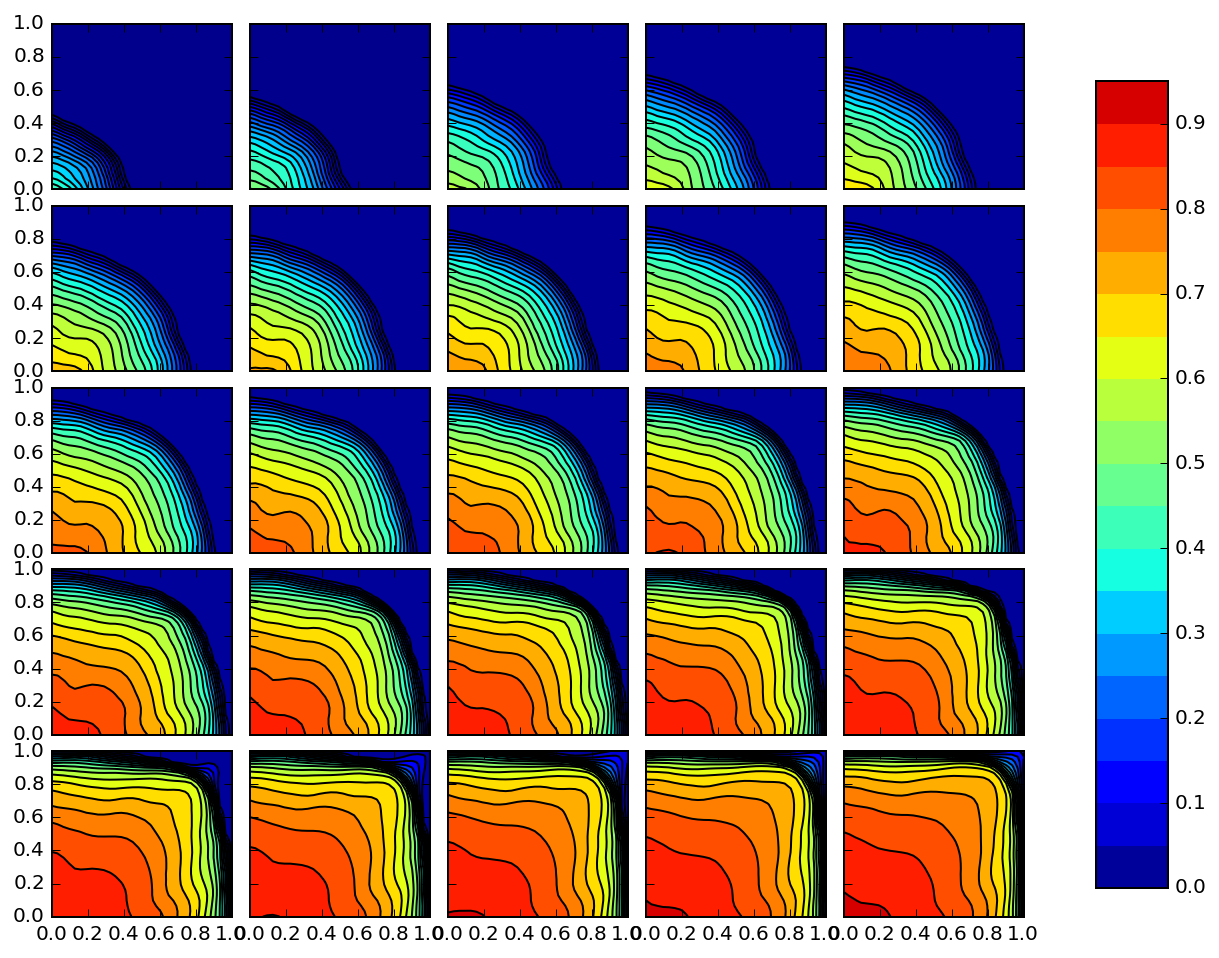

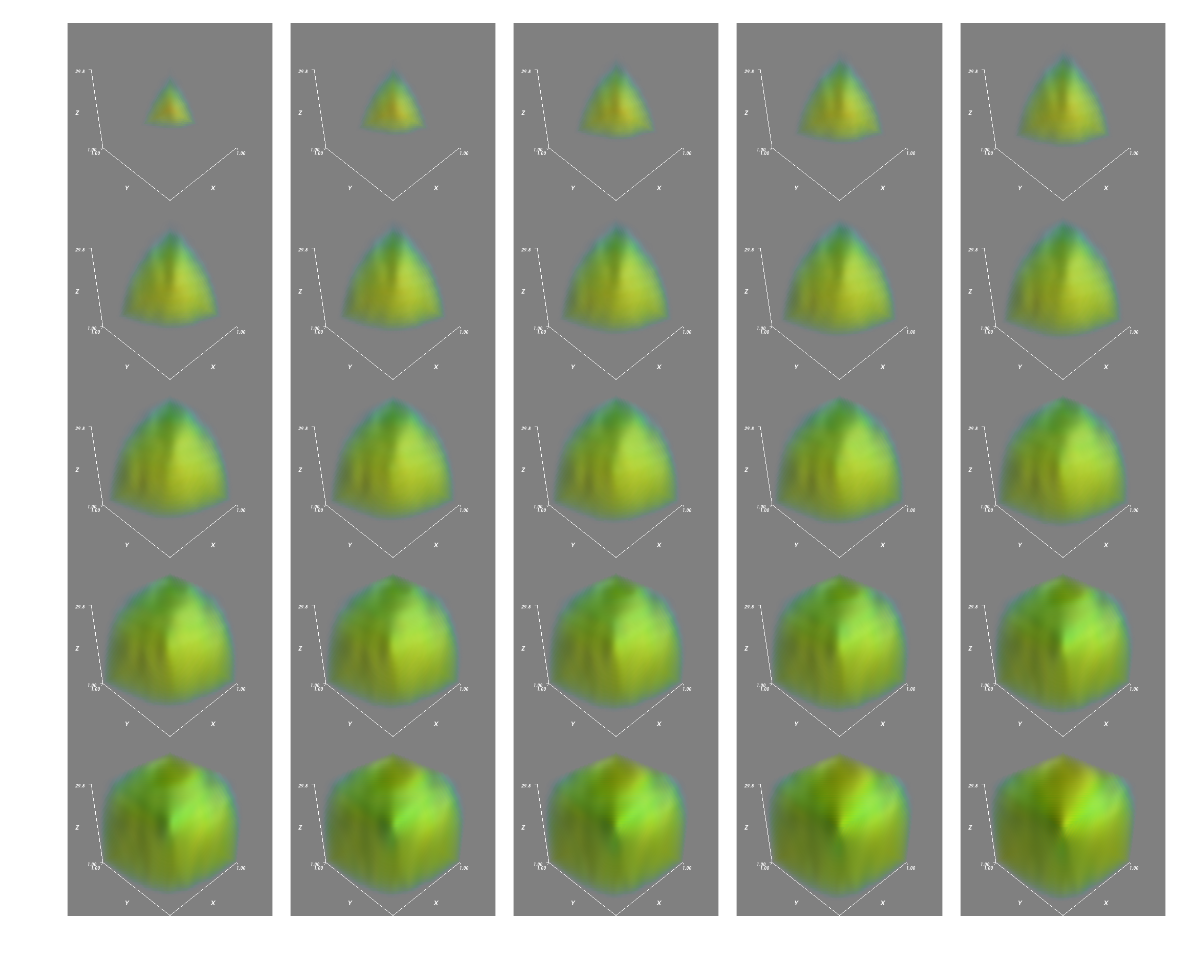

In [23]:
# Symmetric permeability diagonal tensor
K = quasi_random_perm((3, 32, 32, 10))
phi = np.ones((32, 32, 10))
quarter_five_spot_two_phase_incompressible_impes(K, phi)

### Implict discretization
A downside of the implicit pressure explicit saturation discretization above is the CFL condition. We can overcome this by using an implicit discretization of the saturation equation as well. This amounts to changing the explict discretization above,
$$
S^{n+1} = S^n + (\delta_x^t)^T(A f(S^n) + Q^+)
$$  
to an implict discretization
$$
S^{n+1} = S^n + (\delta_x^t)^T(A f(S^{n+1}) + Q^+)
$$  
However, by doing so, we have a nonlinear set of equations (recall that the fractional flow, $f(S)$, is non-linear), which we cannot solve directly through linear algebra. To solve these equations we therefore have to Newton-Raphson or other non-linear solvers.

### Newton-Raphson

Recall that we can derive Newtons method for a function $g(x)$, where we want to find $x$ so that 
$$g(x) = 0$$
Assuming an initial guess $x_n$ for our solution $x$, we can approximate our function around this fix point (through expansion of the first term in the Taylor series) as
$$h(x_{n+1}) = g(x_n) + g'(x_n) (x_{n+1} - x_n)$$
We can now write up $h(x_{n+1}) = 0$, and solve for $x_{n+1}$,
$$
0 = g(x_n) + g'(x_n) (x_{n+1} - x_n)\\
x_{n+1} = x_n - \frac{g(x_n)}{g'(x_n)}
$$
Assuming that $g$ is sufficiently smooth, and that $x_n$ is sufficiently close to $x$, $x_{n+1}$ will be a better approximation, and the method converges quadratically towards the true solution.

Returning to our problem, we can write down the residual
$$
G(S^{n+1}) = S^{n+1} - S^n - (\delta_x^t)^T(A f(S^{n+1}) + Q^+)
$$
and we want to find $S^{n+1}$ so that $G(S^{n+1}) = 0$. 

Writing up one term of the Taylor expansion for our problem, 
$$
0 = G(S_{n}) + G'(S_{n}) (S_{n+1} - S_{n})
$$
and solving for $S_{n+1}$, we get
$$
S_{n+1} = S_{n} - dS_{n}
$$
in which $dS_{n}$ is the solution to the matrix equation
$$
-G'(S_{n}) dS_{n} = G(S_{n})
$$
We can manually differentiaty $G$ to arrive at
$$
G'(S) = I - (\delta_x^t)^TAf'(S)
$$
Recall that
$$
f(S) = \frac{\lambda_{w}(S)}{\lambda_w(S) + \lambda_o(S)} = \frac{g(s)}{h(s)}
$$
so that
$$
\begin{align}
f'(S) 
&= \left(\frac{g(s)}{h(s)}\right)' 
= \frac{g'(s) h(s) - g(s) h'(s)}{h(s)^2} \\
&= \frac{\lambda_w'(s)\left[\lambda_w(s) + \lambda_o(s) \right] - \lambda_w(s) \left[\lambda_w'(s) + \lambda_o'(s) \right]}{\left[\lambda_w(s) + \lambda_o(s) \right]^2 }\\
&= \frac{\lambda_w'(s)}{\lambda_w(s) + \lambda_o(s)} - \frac{\lambda_w(s) \left[\lambda_w'(s) + \lambda_o'(s) \right]}{\left[\lambda_w(s) + \lambda_o(s) \right]^2 }\\
\end{align}
$$
We can implement a solver that is independent of the CFL condition. Unfortunately, however, Newtons method will only converge if we take sufficiently small timesteps (that is, if our initial guess for the saturations is sufficiently close to the true solution).

In [24]:
def newton_raphson(grid, s_init, fluid, vx, vy, vz, q, phi, T):
    """
    Computes the saturation at time t = t+T using the current saturation s,
    the volumetric velocities [vx, vy, vz], and the sources q.
    """
    
    #Tolerance for what we consider converged
    tol = 1e-3
    max_iter = 16
    
    #Shorthand for grid dimensions
    nx = grid.nx
    ny = grid.ny
    nz = grid.nz
    N = nx*ny*nz
    
    # Find the A matrix
    A = compute_A(grid, vx, vy, vz, q)
    
    #Calculate the per cell volume, |\Omega_i|
    omega = grid.dx*grid.dy*grid.dz;
    
    #Find inflow from wells, Q^+
    Qp = np.maximum(q, 0.0)
    Qp = np.reshape(Qp, N, order='F')
    
    #Set initial number of sub-timesteps
    n_ts = 16
    ts = 0
    
    #Reshape our matrices into vectors
    s = np.copy(s_init)
    s = np.reshape(s, N, order='F')
    
    #Iterate until we have reached time T
    while (ts < n_ts):
        # Compute \delta_x^t
        dt = T / float(n_ts)
        d_xt = dt / (phi*omega)
        d_xt = np.reshape(d_xt, N, order='F')
        s0 = np.copy(s)
                
        for i in range(0, max_iter):
            [lmbd_w, lmbd_o, d_lmbd_w, d_lmbd_o] = mobilities(s, fluid)
            
            #Compute f and its the derivative
            f = lmbd_w / (lmbd_w + lmbd_o)
            df = d_lmbd_w / (lmbd_w + lmbd_o) - lmbd_w * (d_lmbd_w + d_lmbd_o) / (lmbd_w + lmbd_o)**2 
            
            #Compute G and its derivative
            G = s - s0 - d_xt*(A*f + Qp)
            dG = 1.0 - d_xt*(A*df)
            dG = sp.sparse.spdiags(dG.transpose(), 0, N, N, format='csr')
            
            #Now find derivative of S
            ds = sp.sparse.linalg.spsolve(-dG, G)
            
            #Update estimate of S and its norm
            s = s + ds
            n_ds = np.linalg.norm(ds)
            #print "Newton-Raphson iteration ", i, ", dt=", dt, ", n_ds=", n_ds
            
            #If we converged, move on to next sub-timestep
            if (n_ds <= tol):
                ts = ts+1
                break
        
        #If we have not converged, try a smaller timestep from now on
        if (n_ds > tol):
            s = np.copy(s0)
            ts = ts*2
            n_ts = n_ts*2
            print "   t=", ts*dt/2.0,"n_ds=", n_ds, ": Trying smaller dt=", T / float(n_ts)
            
            #s = np.copy(s_init)
            #s = np.reshape(s, N, order='F')
            #ts = 0
            #n_ts = 2*n_ts
            #print "   n_ds=", n_ds, ": Trying smaller dt=", T / float(n_ts)

    s = np.reshape(s, (nx, ny, nz), order='F')
    return s

In [25]:
def quarter_five_spot_two_phase_incompressible_full_implicit(K, phi):
    g = Grid()
    f = Fluid()
    
    k_shape = K.shape
    assert k_shape[0] == 3
    
    volumetric = False
    if (K.shape[3] > 1):
        volumetric = True
        
    # Set grid size
    g.nx = k_shape[1]
    g.ny = k_shape[2]
    g.nz = k_shape[3]
    
    # Set domain size
    g.dx = 1.0 / g.nx
    g.dy = 1.0 / g.ny
    g.dz = 1.0 / g.nz
        
    # Set fluid properties
    f.s_wc = 0.0
    f.s_or = 0.0
    f.mu_w = 1.0
    f.mu_o = 1.0
    
    #Set sources/sinks
    q = np.zeros((g.nx, g.ny, g.nz))
    q[0][0][0] = 1.0
    q[-1][-1][-1] = -1.0
    rho = 1.0
    
    #Set initial saturation
    s = np.zeros((g.nx, g.ny, g.nz))
    
    #Set dt for pressure solves,
    #and total simulation time
    nt = 25
    dt = 0.7 / (nt-1)
    
    #for plotting a lot of figures in one
    nx = int(ceil(sqrt(nt)))
    ny = nx
    if (nx*(ny-1) > nt):
        ny = ny-1
    
    #2d plot
    fig_2d, ax_2d = subplots(nx, ny, sharex=True, sharey=True, squeeze=True)
    ax_2d = np.reshape(ax_2d, nx*ny)
    subplots_adjust(right=0.8, wspace=0.1, hspace=0.1)
    coll = None
    X = np.linspace(0, 1, g.nx)
    Y = np.linspace(0, 1, g.ny)
    X, Y = np.meshgrid(X, Y)
    
    #3d plot
    if (volumetric):
        fig_3d, ax_3d = subplots(nx, ny, sharex=True, sharey=True, squeeze=True)
        ax_3d = np.reshape(ax_3d, nx*ny)
        subplots_adjust(wspace=0, hspace=0)
        a = min(g.dx, g.dy, g.dz)
        dx = g.dx / a
        dy = g.dy / a
        dz = g.dz / a
    
    #Finally, simulation loop
    for t in range(nt):
        #Compute the pressure
        [P, vx, vy, vz] = TPFA_twophase(g, K, q/rho, s, f)
        
        #Update saturations
        s = newton_raphson(g, s, f, vx, vy, vz, q, phi, dt)
        
        #2d plot
        coll = ax_2d[t].contour(X, Y, np.average(s, axis=2), 18, colors='k', vmin=0.0, vmax=1.0)
        coll = ax_2d[t].contourf(X, Y, np.average(s, axis=2), 18, vmin=0.0, vmax=1.0)
        #coll = ax_2d[t].pcolor(np.average(s, axis=2), vmin=0.0, vmax=1.0)
        axis('tight')
        
        #3d plot
        if (volumetric):
            volume = mlab.pipeline.scalar_field(s)
            volume.spacing = [dx, dy, dz]
            volume.update_image_data = True
            mlab.pipeline.volume(volume, vmin=0.0, vmax=1.0)
            mlab.axes()
            ax_3d[t].imshow(mlab.screenshot())
            ax_3d[t].axis('off')
            mlab.close()
        
        print "t=", t*dt, ", Max P=", np.max(P), ", Min P=", np.min(P), ", Max S=", np.max(s), ", Min S=", np.min(s)
        
        #Force garbage collection
        gc.collect()
        
    #Add colorbar
    c_ax = fig_2d.add_axes([0.85, 0.15, 0.05, 0.7])
    fig_2d.colorbar(coll, cax=c_ax)
        
    #Turn off the axis in unused subplots
    for t in range(nt+1, nx*ny):
        ax_2d[t].axis('off')

   t= 0.0 n_ds= 48116.3277585 : Trying smaller dt= 0.000911458333333
   t= 0.0 n_ds= 2192095784.07 : Trying smaller dt= 0.000455729166667
t= 0.0 , Max P= 1.22124532709e-15 , Min P= -10.7150833972 , Max S= 0.970959915405 , Min S= 0.0
t= 0.0291666666667 , Max P= 8.24340595784e-15 , Min P= -12.097430823 , Max S= 0.984461831506 , Min S= 0.0
t= 0.0583333333333 , Max P= 9.0483176507e-15 , Min P= -11.8007718646 , Max S= 0.989391605648 , Min S= 0.0
t= 0.0875 , Max P= 1.04916075827e-14 , Min P= -11.6440781013 , Max S= 0.99194607306 , Min S= 0.0
t= 0.116666666667 , Max P= 1.08801856413e-14 , Min P= -11.5444256858 , Max S= 0.993508819587 , Min S= 0.0
t= 0.145833333333 , Max P= -6.88338275268e-15 , Min P= -11.4736393058 , Max S= 0.994563541456 , Min S= 0.0
t= 0.175 , Max P= -1.14630527293e-14 , Min P= -11.4207171745 , Max S= 0.995323353113 , Min S= 0.0
t= 0.204166666667 , Max P= 1.16573417586e-15 , Min P= -11.3799892679 , Max S= 0.995896784706 , Min S= 0.0
t= 0.233333333333 , Max P= -1.38777878078

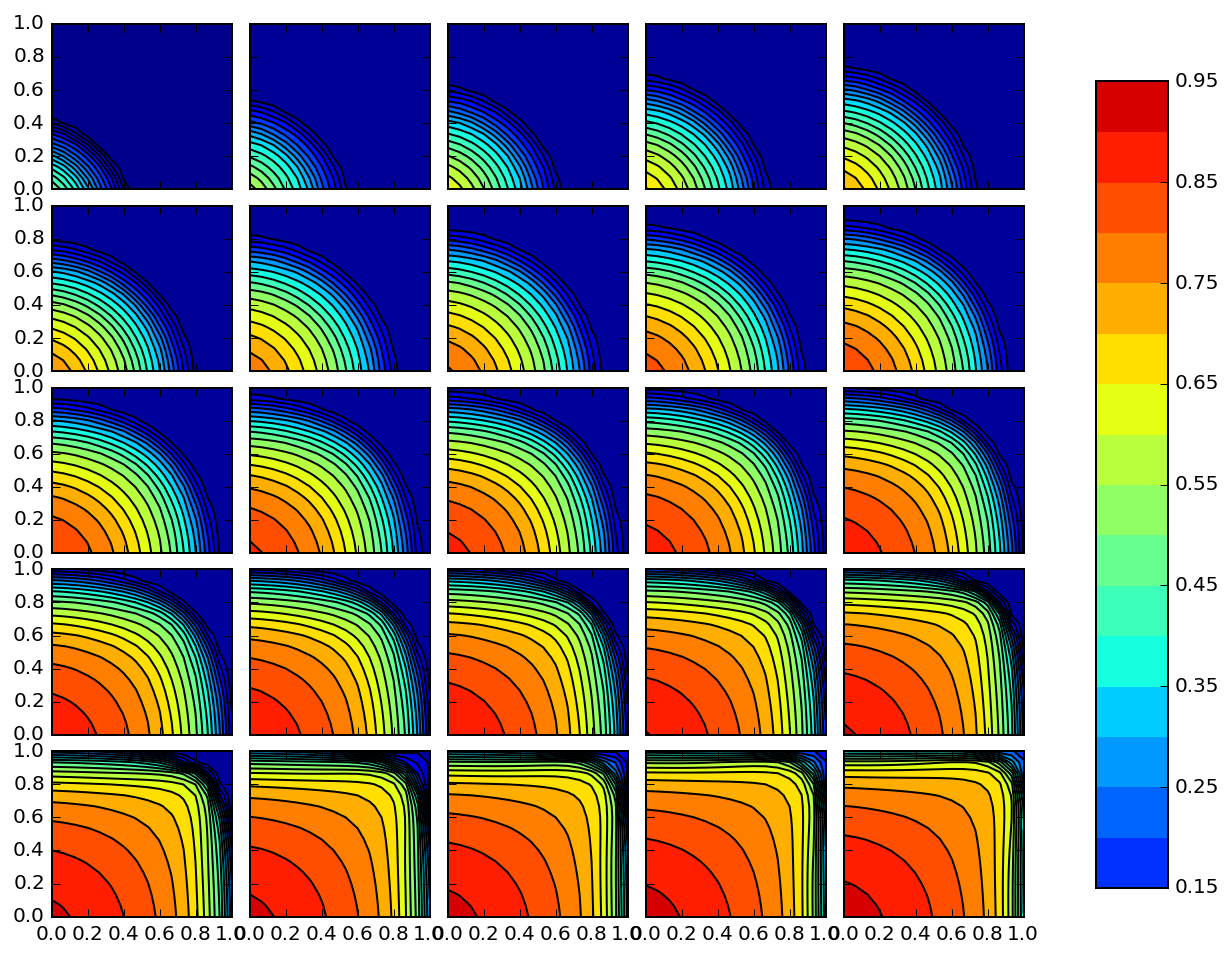

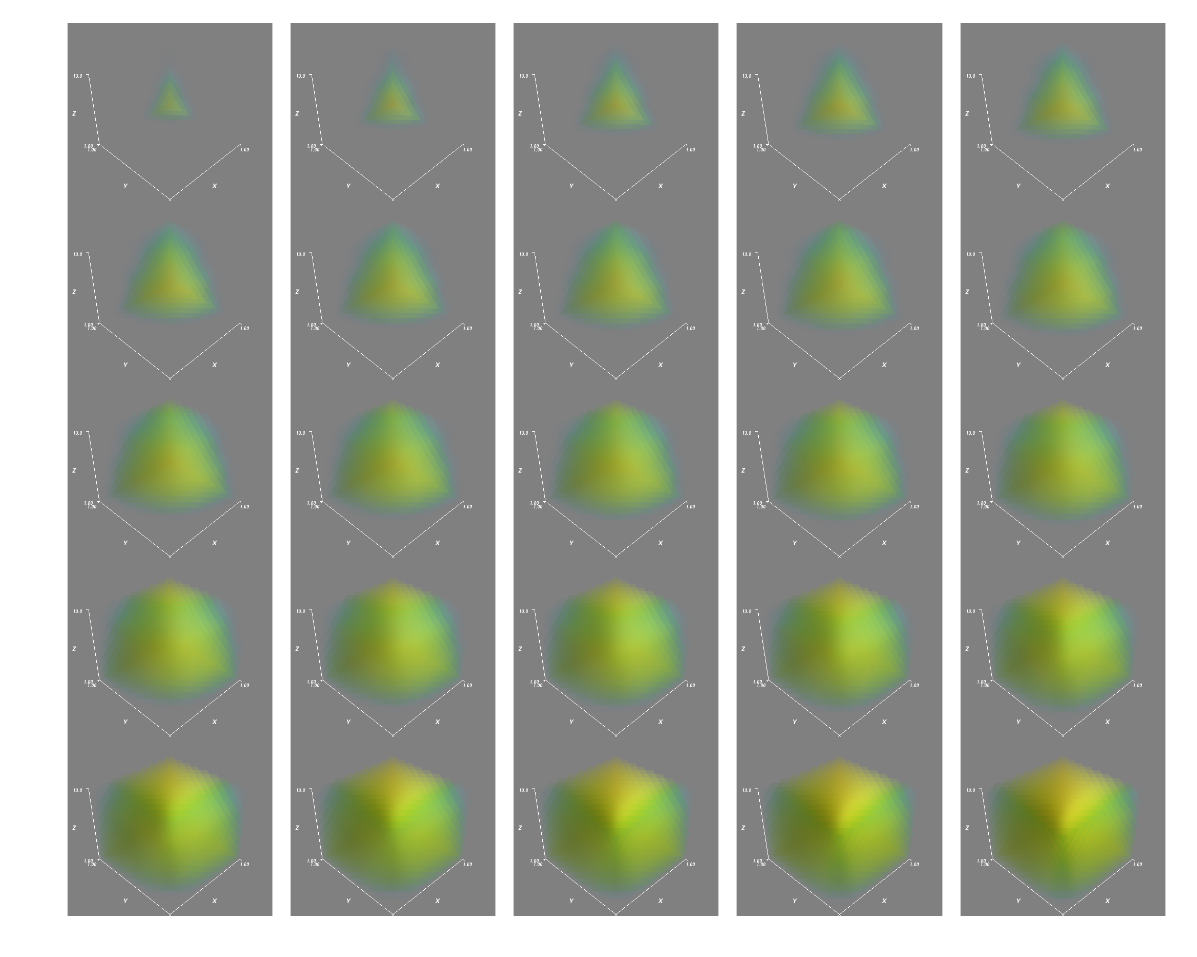

In [26]:
#Run isotropic case
K = np.ones((3, 16, 16, 4))
phi = np.ones((16, 16, 4))
quarter_five_spot_two_phase_incompressible_full_implicit(K, phi)

   t= 0.0 n_ds= 3.21188165412e+16 : Trying smaller dt= 0.000911458333333
   t= 0.0 n_ds= 578311.586901 : Trying smaller dt= 0.000455729166667
   t= 0.0 n_ds= 6913196.49384 : Trying smaller dt= 0.000227864583333
   t= 0.0 n_ds= 12378.3882052 : Trying smaller dt= 0.000113932291667
   t= 0.0 n_ds= 2.06740123481 : Trying smaller dt= 5.69661458333e-05
   t= 0.0 n_ds= 0.0279685106079 : Trying smaller dt= 2.84830729167e-05
t= 0.0 , Max P= 7.17199737099e-15 , Min P= -2.35805201487 , Max S= 0.996747874664 , Min S= 0.0
   t= 0.0 n_ds= 0.165553711039 : Trying smaller dt= 0.000911458333333
t= 0.0291666666667 , Max P= 4.19629608839e-15 , Min P= -2.45745743064 , Max S= 0.998336908602 , Min S= 0.0
t= 0.0583333333333 , Max P= 8.74994521283e-15 , Min P= -2.4340574251 , Max S= 0.998880727577 , Min S= 0.0
t= 0.0875 , Max P= 7.23726634178e-15 , Min P= -2.42259152406 , Max S= 0.999157827431 , Min S= 0.0
t= 0.116666666667 , Max P= 2.52207109364e-15 , Min P= -2.41532027229 , Max S= 0.99932541775 , Min S= 0.0

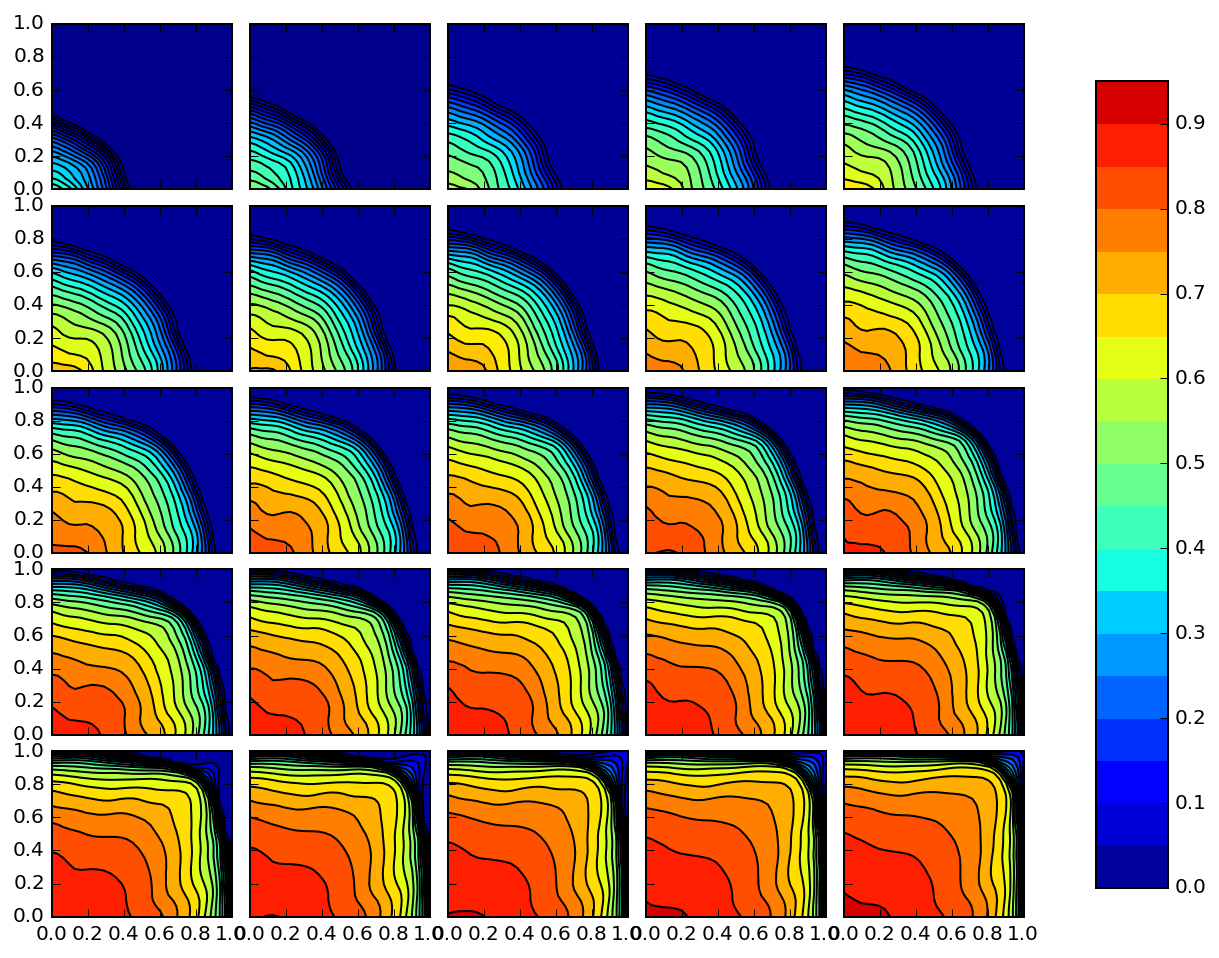

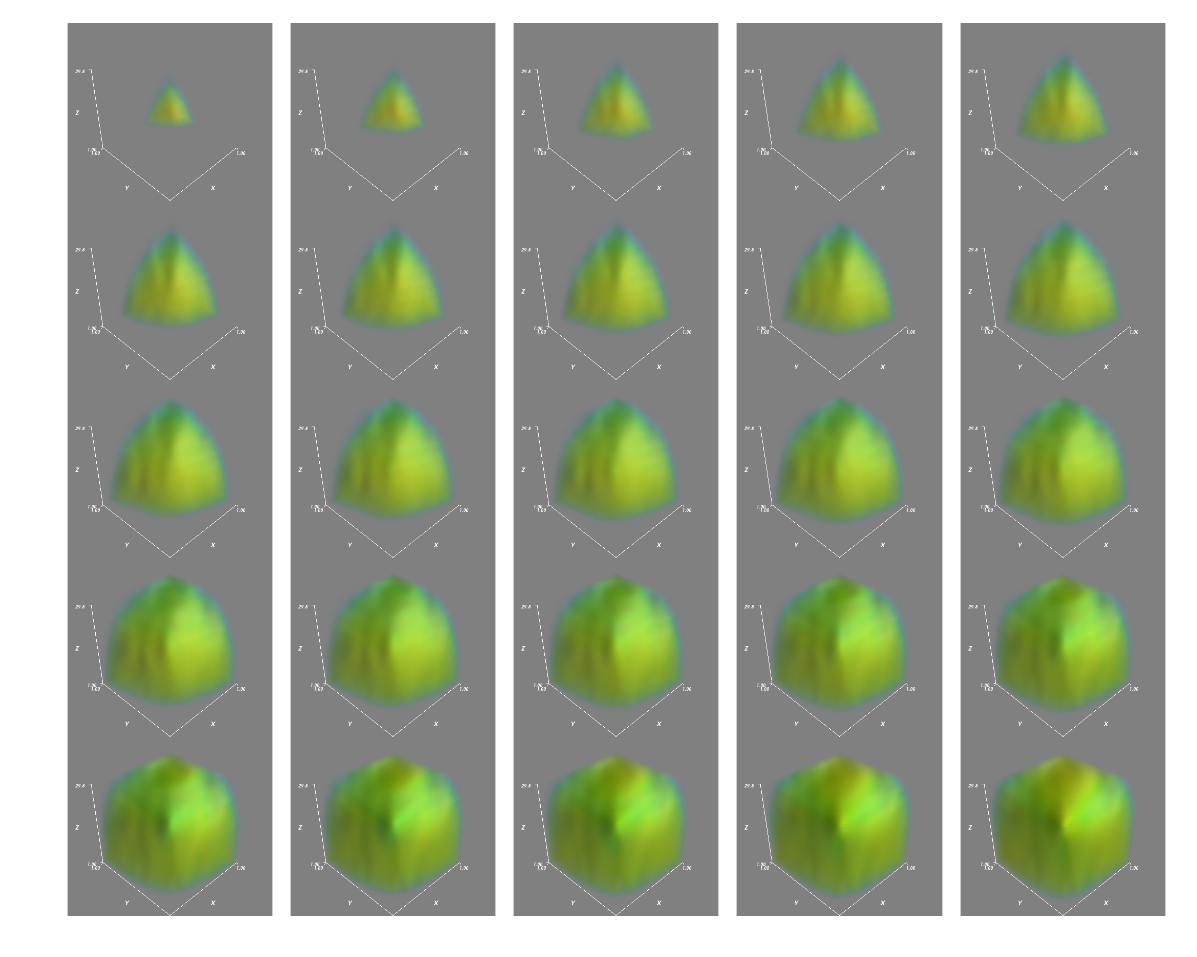

In [27]:
# Symmetric permeability diagonal tensor
K = quasi_random_perm((3, 32, 32, 10))
phi = np.ones((32, 32, 10))
quarter_five_spot_two_phase_incompressible_full_implicit(K, phi)

## Automatic differentiation
The challenge with the above approach, is that we manually have to find the Jacobian of $G$ for the Newton iteration. This can be challenging and time consuming for more complex systems of equations. However, we can use automatic differentiation to let the computer find the Jacobian automatically.

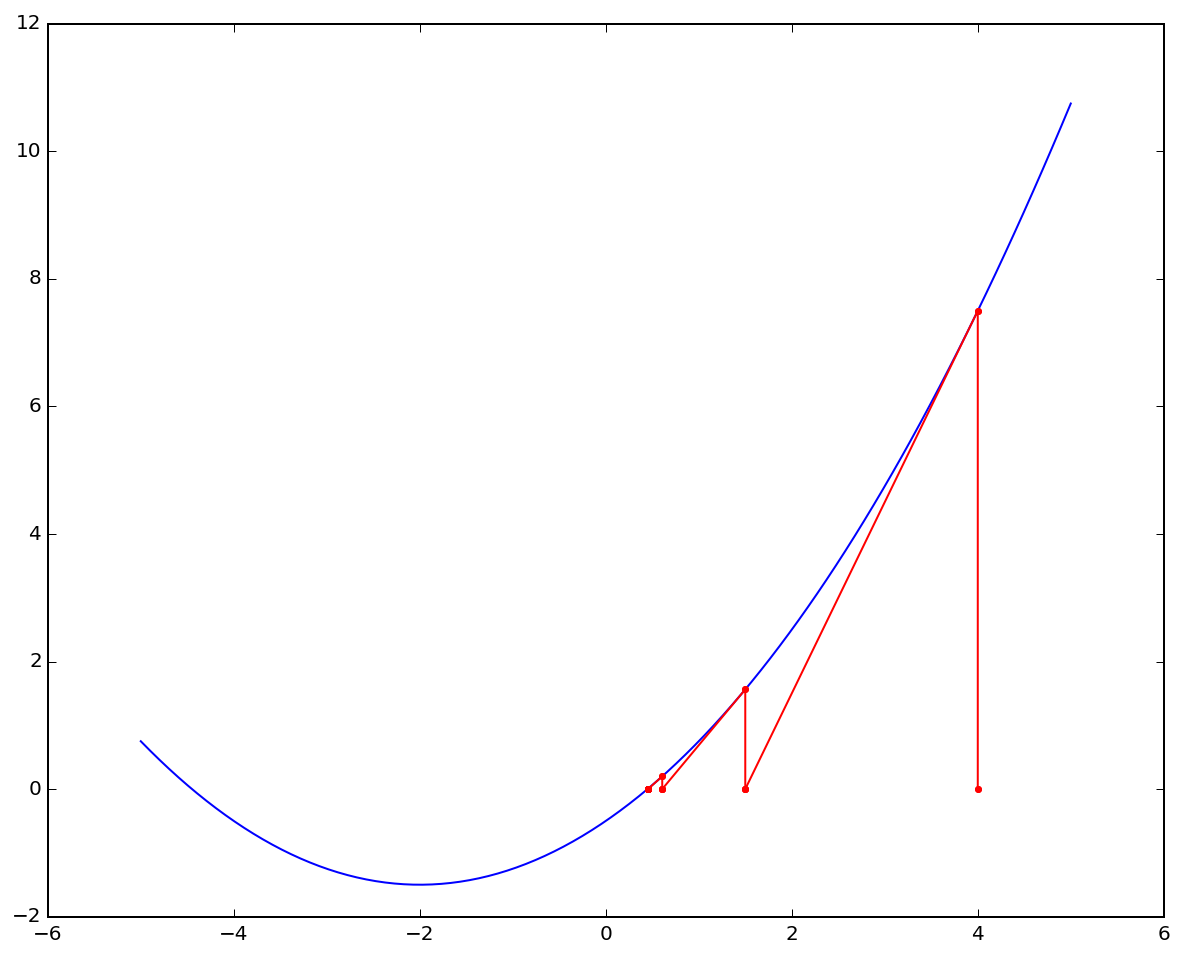

In [227]:
def y_fun(x):
    return (0.5*x+1.0)**2 - 1.5

def test_AD():
    x = np.linspace(-5, 5, 100)
    y = y_fun(x)
    plot(x, y)
    
    #Perform simple newton iteration to find y=0
    x_vals = [4.0]
    for i in range(10):
        #Create AD variable from initial guess
        x0 = ad.adnumber(x_vals[i])
        
        #Evaluate the y function
        y = y_fun(x0)
        
        #Newton step
        x1 = x0 - y / y.d(x0)
        
        #Save the value
        x_vals.append(x1.x)
        
        #Plot
        plot([x0, x0, x1], [0, y, 0], 'r.-')

test_AD()